# Sistema de Detección de Fraude Crediticio Inmobiliario

## Objetivo del Proyecto
Detectar **solicitudes de crédito fraudulentas** mediante la identificación de patrones anómalos, inconsistencias y comportamientos sospechosos en solicitudes de préstamos inmobiliarios.

### Diferencia Clave
- **Impago (default)**: Cliente legítimo que no puede pagar
- **Fraude**: Solicitud con intención de engañar desde el inicio
- **Nuestro enfoque**: Detectar casos con alta probabilidad de ser fraudulentos para revisión humana

## 1. Configuración del Entorno

In [6]:
# Instalación automática de dependencias faltantes
import subprocess
import sys

def instalar_paquete(paquete):
    """Instalar paquete si no está disponible"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", paquete])
        return True
    except:
        return False


In [7]:
# Instalación automática de dependencias faltantes
import subprocess
import sys

def instalar_paquete(paquete):
    """Instalar paquete si no está disponible"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", paquete])
        return True
    except:
        return False

# Verificar e instalar dependencias críticas
dependencias_criticas = ['lightgbm', 'shap']
for dep in dependencias_criticas:
    try:
        __import__(dep)
    except ImportError:
        instalar_paquete(dep)

# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import (roc_auc_score, precision_recall_curve, average_precision_score,
                           precision_score, recall_score, f1_score, roc_curve, confusion_matrix,
                           silhouette_score)

# Gradient Boosting (con alternativa si falla)
try:
    import lightgbm as lgb
    LIGHTGBM_DISPONIBLE = True
    print("LightGBM disponible")
except ImportError:
    from sklearn.ensemble import GradientBoostingClassifier
    LIGHTGBM_DISPONIBLE = False
    print("LightGBM no disponible - usando GradientBoostingClassifier de sklearn")

# Deep Learning (opcional)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    tf.random.set_seed(42)
    TENSORFLOW_DISPONIBLE = True
except ImportError:
    from sklearn.neural_network import MLPRegressor
    TENSORFLOW_DISPONIBLE = False

# Interpretabilidad (opcional)
try:
    import shap
    SHAP_DISPONIBLE = True
except ImportError:
    SHAP_DISPONIBLE = False

# Configuración general
import os
import gc
from typing import Tuple, Dict, List

SEMILLA_ALEATORIA = 42
np.random.seed(SEMILLA_ALEATORIA)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

c:\AA2 - Deteccion-de-fraude-inmobiliario\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LightGBM disponible


## 2. Carga y Exploración de Datos

In [8]:
# Carga de datos
RUTA_DATOS = r"C:\AA2 - Deteccion-de-fraude-inmobiliario\data\data"
df = pd.read_csv(os.path.join(RUTA_DATOS, "application_train.csv"))

# Información básica del dataset
distribucion = df['TARGET'].value_counts()
tasa_base = df['TARGET'].mean()

# Resumen de datos para referencia
info_dataset = {
    'dimensiones': df.shape,
    'distribucion_target': distribucion,
    'tasa_base_riesgo': tasa_base,
    'casos_sin_problemas': distribucion[0],
    'casos_con_problemas': distribucion[1] if 1 in distribucion else 0
}

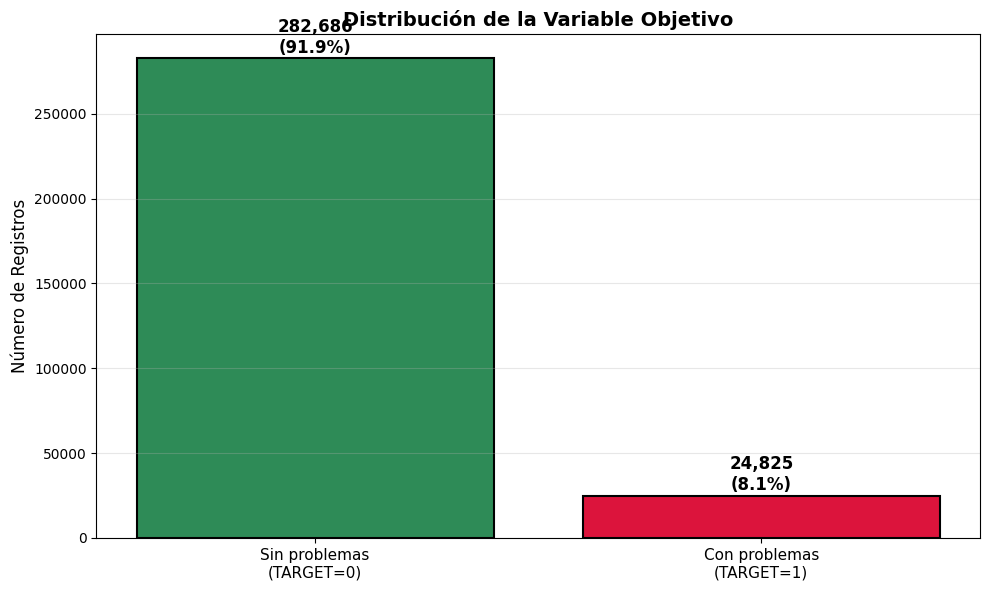

In [9]:
# Visualización de la distribución de TARGET
fig, ax = plt.subplots(figsize=(10, 6))

conteos = df['TARGET'].value_counts()
etiquetas = ['Sin problemas\n(TARGET=0)', 'Con problemas\n(TARGET=1)']
colores = ['#2E8B57', '#DC143C']

barras = ax.bar(range(len(conteos)), conteos.values, color=colores, edgecolor='black', linewidth=1.5)

for i, (barra, valor) in enumerate(zip(barras, conteos.values)):
    altura = barra.get_height()
    porcentaje = valor / len(df) * 100
    ax.text(barra.get_x() + barra.get_width()/2., altura + 1000,
            f'{valor:,}\n({porcentaje:.1f}%)', 
            ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.set_ylabel('Número de Registros', fontsize=12)
ax.set_title('Distribución de la Variable Objetivo', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(etiquetas)))
ax.set_xticklabels(etiquetas, fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [10]:
# Diccionario de traducción de variables a español
TRADUCCION_VARIABLES = {
    # Variables de montos
    'AMT_INCOME_TOTAL': 'INGRESO_TOTAL',
    'AMT_CREDIT': 'MONTO_CREDITO',
    'AMT_ANNUITY': 'ANUALIDAD',
    'AMT_GOODS_PRICE': 'PRECIO_BIENES',
    'AMT_DOWN_PAYMENT': 'PAGO_INICIAL',
    
    # Variables de tiempo
    'DAYS_BIRTH': 'DIAS_NACIMIENTO',
    'DAYS_EMPLOYED': 'DIAS_EMPLEO',
    'DAYS_REGISTRATION': 'DIAS_REGISTRO',
    'DAYS_ID_PUBLISH': 'DIAS_PUBLICACION_ID',
    'DAYS_LAST_PHONE_CHANGE': 'DIAS_CAMBIO_TELEFONO',
    
    # Variables de conteo
    'CNT_CHILDREN': 'NUM_HIJOS',
    'CNT_FAM_MEMBERS': 'NUM_FAMILIARES',
    
    # Variables de información personal
    'NAME_CONTRACT_TYPE': 'TIPO_CONTRATO',
    'CODE_GENDER': 'GENERO',
    'NAME_TYPE_SUITE': 'TIPO_ACOMPANANTE',
    'NAME_INCOME_TYPE': 'TIPO_INGRESO',
    'NAME_EDUCATION_TYPE': 'TIPO_EDUCACION',
    'NAME_FAMILY_STATUS': 'ESTADO_FAMILIAR',
    'NAME_HOUSING_TYPE': 'TIPO_VIVIENDA',
    'OCCUPATION_TYPE': 'TIPO_OCUPACION',
    
    # Variables de contacto
    'FLAG_MOBIL': 'TIENE_MOVIL',
    'FLAG_EMP_PHONE': 'TIENE_TELEFONO_TRABAJO',
    'FLAG_WORK_PHONE': 'TIENE_TELEFONO_OFICINA',
    'FLAG_CONT_MOBILE': 'CONTACTO_MOVIL',
    'FLAG_PHONE': 'TIENE_TELEFONO',
    'FLAG_EMAIL': 'TIENE_EMAIL',
    
    # Fuentes externas
    'EXT_SOURCE_1': 'FUENTE_EXTERNA_1',
    'EXT_SOURCE_2': 'FUENTE_EXTERNA_2',
    'EXT_SOURCE_3': 'FUENTE_EXTERNA_3',
    
    # Variables de región
    'REGION_POPULATION_RELATIVE': 'POBLACION_RELATIVA_REGION',
    'REGION_RATING_CLIENT': 'RATING_CLIENTE_REGION',
    'REGION_RATING_CLIENT_W_CITY': 'RATING_CLIENTE_CIUDAD',
    
    # Variable objetivo
    'TARGET': 'OBJETIVO'
}

def traducir_columnas(df, diccionario_traduccion):
    """Traduce nombres de columnas usando el diccionario"""
    return df.rename(columns=diccionario_traduccion)

# Análisis de variables numéricas clave
variables_clave = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
df_analisis = df[variables_clave + ['TARGET']].copy()

# Convertir días a años para mejor interpretación
df_analisis['EDAD'] = -df_analisis['DAYS_BIRTH'] / 365.25
df_analisis['ANOS_EMPLEO'] = -df_analisis['DAYS_EMPLOYED'] / 365.25

# Manejar valor especial en DAYS_EMPLOYED
df_analisis.loc[df['DAYS_EMPLOYED'] == 365243, 'ANOS_EMPLEO'] = np.nan

# Estadísticas descriptivas por TARGET
stats_resumen = {}
for var in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'EDAD']:
    if var in df_analisis.columns:
        stats_resumen[var] = df_analisis.groupby('TARGET')[var].describe().round(1)

## 3. Features para Detección de Fraude

En esta sección crearemos features específicas para identificar patrones fraudulentos:
- Inconsistencias en datos personales y laborales
- Ratios financieros sospechosos
- Patrones de comportamiento atípicos
- Señales de alerta de fraude conocidas

In [11]:
class ProcesadorDatos:
    def __init__(self, semilla=42, traducir_variables=True):
        self.semilla = semilla
        self.traducir_variables = traducir_variables
        self.imputador_num = SimpleImputer(strategy='median')
        self.imputador_cat = SimpleImputer(strategy='most_frequent')
        self.escalador = RobustScaler()
        self.codificadores = {}
        self.columnas_num = None
        self.columnas_cat = None
        self.mapeo_traduccion = {}
        
    def ajustar(self, X, y=None):
        # Identificar tipos de columnas
        self.columnas_num = X.select_dtypes(include=[np.number]).columns.tolist()
        self.columnas_cat = X.select_dtypes(include=['object']).columns.tolist()
        
        # Remover columnas ID
        self.columnas_num = [col for col in self.columnas_num if 'ID' not in col.upper()]
        
        # Ajustar imputadores
        if self.columnas_num:
            self.imputador_num.fit(X[self.columnas_num])
        if self.columnas_cat:
            self.imputador_cat.fit(X[self.columnas_cat])
            
        # Preparar codificadores para categóricas
        for col in self.columnas_cat:
            if col in X.columns:
                # Target encoding para alta cardinalidad
                if X[col].nunique() > 10 and y is not None:
                    # Crear DataFrame temporal para el cálculo
                    temp_df = pd.DataFrame({col: X[col], 'target': y})
                    media_target = temp_df.groupby(col)['target'].mean()
                    self.codificadores[col] = {'tipo': 'target', 'media': media_target, 
                                              'global': y.mean()}
                # Label encoding para baja cardinalidad
                else:
                    le = LabelEncoder()
                    le.fit(X[col].fillna('FALTANTE').astype(str))
                    self.codificadores[col] = {'tipo': 'label', 'encoder': le}
        return self
        
    def transformar(self, X):
        X_trans = X.copy()
        
        # Imputación (con nombres originales)
        if self.columnas_num:
            X_trans[self.columnas_num] = self.imputador_num.transform(X_trans[self.columnas_num])
        if self.columnas_cat:
            X_trans[self.columnas_cat] = self.imputador_cat.transform(X_trans[self.columnas_cat])
            
        # Codificación de categóricas (con nombres originales)
        for col in self.columnas_cat:
            if col in self.codificadores and col in X_trans.columns:
                if self.codificadores[col]['tipo'] == 'target':
                    # Target encoding: convertir a numérico
                    media = self.codificadores[col]['media']
                    global_mean = self.codificadores[col]['global']
                    X_trans[col] = X_trans[col].map(media).fillna(global_mean)
                else:
                    # Label encoding: convertir a numérico
                    le = self.codificadores[col]['encoder']
                    valores = X_trans[col].fillna('FALTANTE').astype(str)
                    X_trans[col] = valores.map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        
        # Eliminar categóricas restantes (por si quedara alguna)
        X_trans = X_trans.select_dtypes(include=[np.number])
        
        # Actualizar columnas numéricas finales
        columnas_num_finales = [col for col in self.columnas_num if col in X_trans.columns]
        
        # Escalado (con nombres originales)
        if columnas_num_finales:
            if not hasattr(self.escalador, 'scale_'):
                self.escalador.fit(X_trans[columnas_num_finales])
            X_trans[columnas_num_finales] = self.escalador.transform(X_trans[columnas_num_finales])
        
        # Aplicar traducción de variables AL FINAL si está habilitada
        if self.traducir_variables:
            X_trans = traducir_columnas(X_trans, TRADUCCION_VARIABLES)
            # Guardar mapeo para referencia futura
            self.mapeo_traduccion = {v: k for k, v in TRADUCCION_VARIABLES.items() if k in X.columns}
            
        return X_trans

# Crear muestra estratificada significativa (50k registros para rapidez)
TAMAÑO_MUESTRA = 50000  # Muestra representativa pero manejable

# Crear muestra estratificada manteniendo proporciones de TARGET
df_muestra = df.groupby('TARGET', group_keys=False).apply(
    lambda x: x.sample(min(len(x), int(TAMAÑO_MUESTRA * len(x) / len(df))), 
                      random_state=SEMILLA_ALEATORIA)
).reset_index(drop=True)

print(f"Dataset original: {len(df):,} registros")
print(f"Muestra estratificada: {len(df_muestra):,} registros ({len(df_muestra)/len(df)*100:.1f}%)")
print(f"Distribución original TARGET: {df['TARGET'].value_counts(normalize=True).values}")
print(f"Distribución muestra TARGET: {df_muestra['TARGET'].value_counts(normalize=True).values}")

# División estratificada del dataset muestreado
X = df_muestra.drop(['TARGET', 'SK_ID_CURR'], axis=1, errors='ignore')
y = df_muestra['TARGET']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEMILLA_ALEATORIA, stratify=y
)

# Crear conjunto de prueba desde validación
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=SEMILLA_ALEATORIA, stratify=y_val
)

# Aplicar preprocesamiento con traducción
procesador = ProcesadorDatos(SEMILLA_ALEATORIA, traducir_variables=True)
procesador.ajustar(X_train, y_train)

X_train_proc = procesador.transformar(X_train)
X_val_proc = procesador.transformar(X_val)
X_test_proc = procesador.transformar(X_test)

# Resumen de preprocesamiento
resumen_preprocesamiento = {
    'registros_entrenamiento': len(X_train),
    'registros_validacion': len(X_val),
    'registros_prueba': len(X_test),
    'features_originales': X_train.shape[1],
    'features_procesadas': X_train_proc.shape[1],
    'variables_traducidas': len([k for k in TRADUCCION_VARIABLES.keys() if k in X_train.columns])
}

print(f"Features después del preprocesamiento: {X_train_proc.shape[1]}")
print(f"Variables traducidas: {resumen_preprocesamiento['variables_traducidas']}")
print(f"División: {len(X_train)} entrenamiento, {len(X_val)} validación, {len(X_test)} prueba")

Dataset original: 307,511 registros
Muestra estratificada: 49,999 registros (16.3%)
Distribución original TARGET: [0.91927118 0.08072882]
Distribución muestra TARGET: [0.91927839 0.08072161]
Features después del preprocesamiento: 120
Variables traducidas: 31
División: 39999 entrenamiento, 5000 validación, 5000 prueba
Features después del preprocesamiento: 120
Variables traducidas: 31
División: 39999 entrenamiento, 5000 validación, 5000 prueba


## 4. Construcción de Reglas de Negocio e Índices de Ambigüedad

In [12]:
class GeneradorReglasNegocio:
    def __init__(self):
        self.umbrales = {}
        self.reglas_aplicadas = []
        
    def calibrar_umbrales(self, df_train):
        """Calibrar umbrales basados en datos de entrenamiento"""
        
        # Umbral para ratio crédito/ingreso
        if 'AMT_CREDIT' in df_train.columns and 'AMT_INCOME_TOTAL' in df_train.columns:
            ratio_credito_ingreso = df_train['AMT_CREDIT'] / (df_train['AMT_INCOME_TOTAL'] + 1)
            self.umbrales['ratio_credito_alto'] = ratio_credito_ingreso.quantile(0.95)
            
        # Umbral para ratio anualidad/ingreso  
        if 'AMT_ANNUITY' in df_train.columns and 'AMT_INCOME_TOTAL' in df_train.columns:
            ratio_anualidad_ingreso = df_train['AMT_ANNUITY'] / (df_train['AMT_INCOME_TOTAL'] + 1)
            self.umbrales['ratio_anualidad_alto'] = ratio_anualidad_ingreso.quantile(0.90)
            
        # Umbral para ingreso bajo
        if 'AMT_INCOME_TOTAL' in df_train.columns:
            self.umbrales['ingreso_bajo'] = df_train['AMT_INCOME_TOTAL'].quantile(0.20)
            
        return self
        
    def generar_reglas(self, df):
        """Generar flags de ambigüedad basados en reglas de negocio"""
        
        reglas_df = pd.DataFrame(index=df.index)
        
        # REGLA 1: Edad fuera de rango normal (menor 18 o mayor 80 años)
        if 'DAYS_BIRTH' in df.columns:
            edad_anos = -df['DAYS_BIRTH'] / 365.25
            reglas_df['AMB_EDAD_EXTREMA'] = ((edad_anos < 18) | (edad_anos > 80)).astype(int)
            self.reglas_aplicadas.append('AMB_EDAD_EXTREMA: Edad menor a 18 o mayor a 80 años')
            
        # REGLA 2: Días empleado con valor especial (indicador de datos faltantes)
        if 'DAYS_EMPLOYED' in df.columns:
            reglas_df['AMB_EMPLEO_FALTANTE'] = (df['DAYS_EMPLOYED'] == 365243).astype(int)
            self.reglas_aplicadas.append('AMB_EMPLEO_FALTANTE: DAYS_EMPLOYED con valor especial 365243')
            
        # REGLA 3: Antigüedad laboral inconsistente con edad
        if 'DAYS_BIRTH' in df.columns and 'DAYS_EMPLOYED' in df.columns:
            edad_anos = -df['DAYS_BIRTH'] / 365.25
            anos_empleo = -df['DAYS_EMPLOYED'] / 365.25
            # Solo considerar casos con empleo válido
            mask_empleo_valido = df['DAYS_EMPLOYED'] != 365243
            edad_laboral_minima = edad_anos - 16  # Asumiendo edad mínima laboral 16 años
            inconsistencia = mask_empleo_valido & (anos_empleo > edad_laboral_minima)
            reglas_df['AMB_EMPLEO_INCONSISTENTE'] = inconsistencia.astype(int)
            self.reglas_aplicadas.append('AMB_EMPLEO_INCONSISTENTE: Antigüedad laboral mayor a edad laboral posible')
            
        # REGLA 4: Ratio crédito/ingreso sospechosamente alto
        if ('AMT_CREDIT' in df.columns and 'AMT_INCOME_TOTAL' in df.columns and 
            'ratio_credito_alto' in self.umbrales):
            ratio_credito = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)
            reglas_df['AMB_RATIO_CREDITO_ALTO'] = (
                ratio_credito > self.umbrales['ratio_credito_alto']
            ).astype(int)
            self.reglas_aplicadas.append(f'AMB_RATIO_CREDITO_ALTO: Ratio crédito/ingreso > {self.umbrales["ratio_credito_alto"]:.2f}')
            
        # REGLA 5: Familia vulnerable (muchos hijos + ingreso bajo)
        if ('CNT_CHILDREN' in df.columns and 'AMT_INCOME_TOTAL' in df.columns and
            'ingreso_bajo' in self.umbrales):
            reglas_df['AMB_FAMILIA_VULNERABLE'] = (
                (df['CNT_CHILDREN'] >= 3) & 
                (df['AMT_INCOME_TOTAL'] <= self.umbrales['ingreso_bajo'])
            ).astype(int)
            self.reglas_aplicadas.append(f'AMB_FAMILIA_VULNERABLE: 3+ hijos con ingreso <= {self.umbrales["ingreso_bajo"]:,.0f}')
            
        # REGLA 6: Información de contacto limitada
        columnas_contacto = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_EMAIL']
        cols_disponibles = [col for col in columnas_contacto if col in df.columns]
        if cols_disponibles:
            suma_contacto = df[cols_disponibles].sum(axis=1)
            reglas_df['AMB_CONTACTO_LIMITADO'] = (suma_contacto <= 1).astype(int)
            self.reglas_aplicadas.append('AMB_CONTACTO_LIMITADO: Solo 1 o menos medios de contacto')
            
        # REGLA 7: Fuentes externas completamente faltantes
        columnas_ext = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
        cols_ext_disponibles = [col for col in columnas_ext if col in df.columns]
        if cols_ext_disponibles:
            ext_faltantes = df[cols_ext_disponibles].isnull().sum(axis=1)
            reglas_df['AMB_SIN_FUENTES_EXTERNAS'] = (
                ext_faltantes == len(cols_ext_disponibles)
            ).astype(int)
            self.reglas_aplicadas.append('AMB_SIN_FUENTES_EXTERNAS: Todas las fuentes externas faltantes')
        
        # Calcular Índice de Ambigüedad (IA) con pesos calibrados
        columnas_ambiguedad = [col for col in reglas_df.columns if col.startswith('AMB_')]
        
        if columnas_ambiguedad:
            # Pesos basados en severidad e impacto en el negocio
            pesos = {
                'AMB_EDAD_EXTREMA': 3.0,                # Muy crítico - datos imposibles
                'AMB_EMPLEO_INCONSISTENTE': 2.5,        # Crítico - inconsistencia temporal
                'AMB_RATIO_CREDITO_ALTO': 2.0,          # Alto - indicador financiero
                'AMB_FAMILIA_VULNERABLE': 1.5,          # Medio - factor socioeconómico
                'AMB_EMPLEO_FALTANTE': 1.0,             # Medio - calidad de datos
                'AMB_CONTACTO_LIMITADO': 1.0,           # Medio - verificabilidad
                'AMB_SIN_FUENTES_EXTERNAS': 0.5         # Bajo - información complementaria
            }
            
            # Calcular IA como suma ponderada
            ia_score = pd.Series(0.0, index=reglas_df.index)
            for columna in columnas_ambiguedad:
                peso = pesos.get(columna, 1.0)
                ia_score += reglas_df[columna] * peso
                
            reglas_df['IA'] = ia_score
            
        return reglas_df

# Aplicar reglas de negocio
generador_reglas = GeneradorReglasNegocio()
generador_reglas.calibrar_umbrales(X_train)

# Generar reglas para todos los conjuntos
reglas_train = generador_reglas.generar_reglas(X_train)
reglas_val = generador_reglas.generar_reglas(X_val)
reglas_test = generador_reglas.generar_reglas(X_test)

# Resumen de reglas aplicadas
reglas_aplicadas_resumen = {
    'total_reglas': len(generador_reglas.reglas_aplicadas),
    'reglas_detalle': generador_reglas.reglas_aplicadas,
    'estadisticas_ia': reglas_train['IA'].describe().round(2)
}

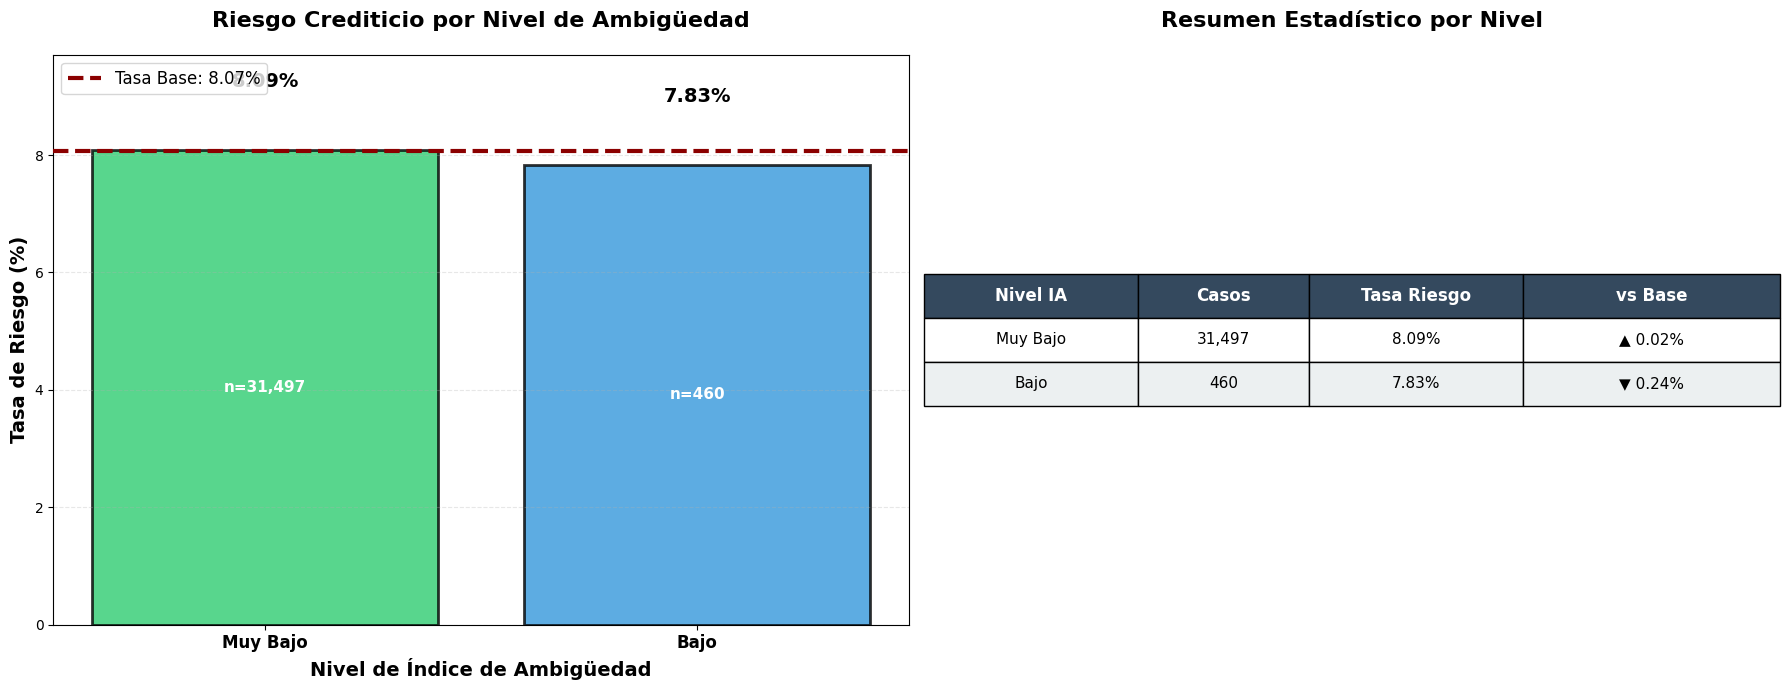


RESUMEN DEL ÍNDICE DE AMBIGÜEDAD
Tasa base de riesgo: 8.07%
Nivel con mayor riesgo: Muy Bajo (8.09%)
Nivel con menor riesgo: Bajo (7.83%)



In [13]:
# Visualización mejorada: Tasa de riesgo por nivel de Índice de Ambigüedad
datos_combinados = pd.concat([reglas_train, y_train.reset_index(drop=True)], axis=1)

# Discretizar IA en 5 grupos para mejor visualización
ia_bins = pd.qcut(datos_combinados['IA'], q=5, duplicates='drop')
analisis_ia = datos_combinados.groupby(ia_bins).agg({
    'TARGET': ['mean', 'count']
}).round(4)
analisis_ia.columns = ['Tasa_Riesgo', 'Conteo']

# Crear etiquetas según el número real de bins
niveles_labels = ['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto']
num_bins = len(analisis_ia)
if num_bins < 5:
    niveles_labels = niveles_labels[:num_bins]
analisis_ia.index = niveles_labels

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# GRÁFICO 1: Barras con tasa de riesgo
colores_map = {
    'Muy Bajo': '#2ecc71',
    'Bajo': '#3498db', 
    'Medio': '#f39c12',
    'Alto': '#e74c3c',
    'Muy Alto': '#c0392b'
}
colores = [colores_map.get(label, '#95a5a6') for label in niveles_labels]

barras = ax1.bar(range(len(analisis_ia)), analisis_ia['Tasa_Riesgo'] * 100, 
                 color=colores, alpha=0.8, edgecolor='black', linewidth=2)

# Línea de referencia
tasa_base = datos_combinados['TARGET'].mean() * 100
ax1.axhline(y=tasa_base, color='darkred', linestyle='--', linewidth=3,
            label=f'Tasa Base: {tasa_base:.2f}%', zorder=5)

# Etiquetas en barras
for i, (barra, (idx, row)) in enumerate(zip(barras, analisis_ia.iterrows())):
    altura = barra.get_height()
    # Porcentaje
    ax1.text(barra.get_x() + barra.get_width()/2., altura + 1,
             f'{altura:.2f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')
    # Conteo
    ax1.text(barra.get_x() + barra.get_width()/2., altura/2,
             f'n={int(row["Conteo"]):,}', ha='center', va='center', 
             fontsize=11, color='white', fontweight='bold')

ax1.set_xlabel('Nivel de Índice de Ambigüedad', fontsize=14, fontweight='bold')
ax1.set_ylabel('Tasa de Riesgo (%)', fontsize=14, fontweight='bold')
ax1.set_title('Riesgo Crediticio por Nivel de Ambigüedad', fontsize=16, fontweight='bold', pad=20)
ax1.set_xticks(range(len(analisis_ia)))
ax1.set_xticklabels(analisis_ia.index, fontsize=12, fontweight='bold')
ax1.legend(fontsize=12, loc='upper left')
ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
ax1.set_ylim(0, max(analisis_ia['Tasa_Riesgo'] * 100) * 1.2)

# GRÁFICO 2: Tabla resumen
ax2.axis('tight')
ax2.axis('off')

# Preparar datos para tabla
tabla_datos = []
for idx, row in analisis_ia.iterrows():
    tasa_pct = row['Tasa_Riesgo'] * 100
    diferencia = tasa_pct - tasa_base
    simbolo = '▲' if diferencia > 0 else '▼' if diferencia < 0 else '='
    
    tabla_datos.append([
        str(idx),
        f"{int(row['Conteo']):,}",
        f"{tasa_pct:.2f}%",
        f"{simbolo} {abs(diferencia):.2f}%"
    ])

tabla = ax2.table(cellText=tabla_datos,
                  colLabels=['Nivel IA', 'Casos', 'Tasa Riesgo', 'vs Base'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.25, 0.2, 0.25, 0.3])

tabla.auto_set_font_size(False)
tabla.set_fontsize(11)
tabla.scale(1, 2.5)

# Estilo de encabezados
for i in range(4):
    tabla[(0, i)].set_facecolor('#34495e')
    tabla[(0, i)].set_text_props(weight='bold', color='white', fontsize=12)

# Estilo de celdas
for i in range(1, len(tabla_datos) + 1):
    for j in range(4):
        if i % 2 == 0:
            tabla[(i, j)].set_facecolor('#ecf0f1')
        tabla[(i, j)].set_text_props(fontsize=11)

ax2.set_title('Resumen Estadístico por Nivel', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"RESUMEN DEL ÍNDICE DE AMBIGÜEDAD")
print(f"{'='*70}")
print(f"Tasa base de riesgo: {tasa_base:.2f}%")
print(f"Nivel con mayor riesgo: {analisis_ia['Tasa_Riesgo'].idxmax()} ({analisis_ia['Tasa_Riesgo'].max()*100:.2f}%)")
print(f"Nivel con menor riesgo: {analisis_ia['Tasa_Riesgo'].idxmin()} ({analisis_ia['Tasa_Riesgo'].min()*100:.2f}%)")
print(f"{'='*70}\n")

analisis_deciles_ia = analisis_ia.copy()

# Visualización: Distribución de scores de anomalía por TARGET incluyendo t-SNE
datos_viz = pd.concat([anomalias_train, y_train.reset_index(drop=True)], axis=1)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

scores_analizar = ['ERROR_RECONSTRUCCION', 'SCORE_ISOLATION', 'SCORE_LOF', 'SCORE_TSNE_CLUSTER']
titulos = ['Error de Reconstrucción (Autoencoder)', 'Score Isolation Forest', 
           'Score Local Outlier Factor', 'Score t-SNE Clustering']

for i, (score_col, titulo) in enumerate(zip(scores_analizar, titulos)):
    scores_target_0 = datos_viz[datos_viz['TARGET']==0][score_col]
    scores_target_1 = datos_viz[datos_viz['TARGET']==1][score_col]
    
    axes[i].hist(scores_target_0, bins=50, alpha=0.7, label='TARGET=0 (Sin problemas)', 
                density=True, color='steelblue')
    axes[i].hist(scores_target_1, bins=50, alpha=0.7, label='TARGET=1 (Con problemas)', 
                density=True, color='coral')
    
    axes[i].set_title(titulo, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Score Normalizado')
    axes[i].set_ylabel('Densidad')
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de correlación con TARGET
print("Correlación de features de anomalía con TARGET:")
for col in scores_analizar:
    corr = datos_viz[col].corr(datos_viz['TARGET'])
    print(f"  {col}: {corr:.4f}")


Análisis detallado del Índice de Ambigüedad (IA):
Efectividad por quintiles del Índice de Ambigüedad (IA):
           Tasa_Riesgo  Total_Casos  Casos_Positivos
Q1 (Bajo)        0.081        31497           2547.0
Q2 (Alto)        0.078          460             36.0


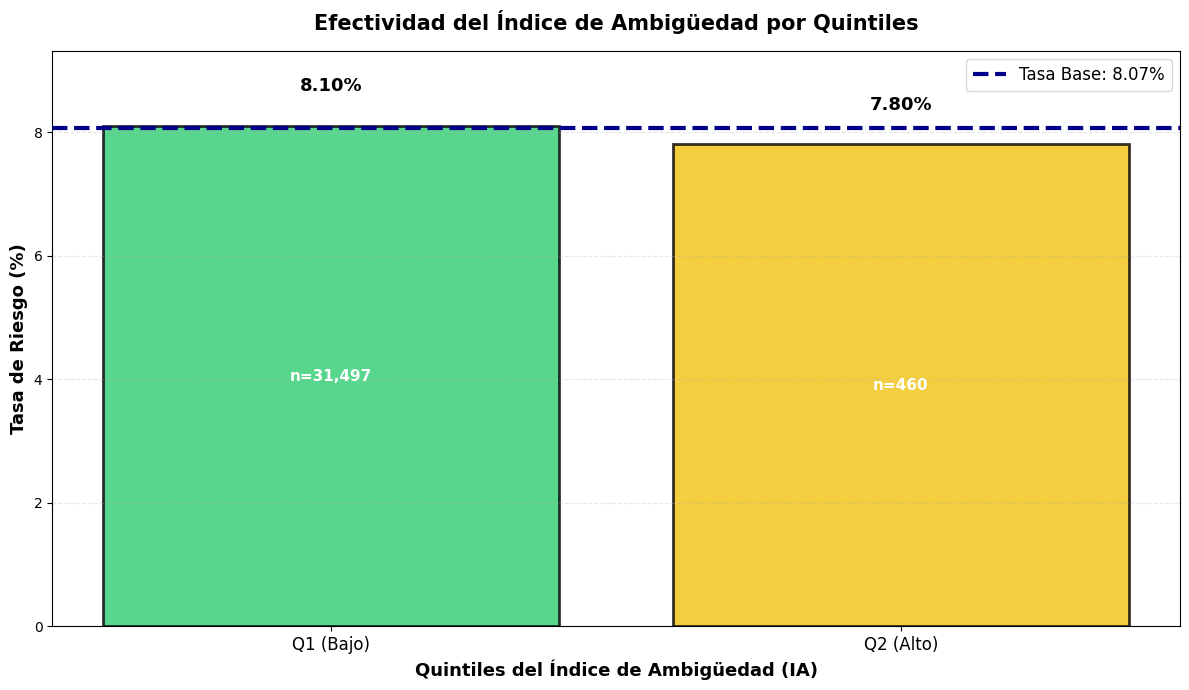


MÉTRICAS DE EFECTIVIDAD ÍNDICE DE AMBIGÜEDAD (IA)
Lift del quintil más alto: 0.97x
Concentración de casos de riesgo en Q2 (Alto): 1.1%
Tasa de riesgo Q2 (Alto): 7.80%
Tasa de riesgo Q1 (Bajo): 8.10%
Ratio Alto/Bajo: 0.96x



In [14]:
# Análisis de efectividad del Índice de Ambigüedad (IA)

# Verificar que reglas_train existe
if 'reglas_train' not in locals() and 'reglas_train' not in globals():
    print("ERROR: Se necesita ejecutar la celda de generación de reglas de negocio primero")
    raise ValueError("La variable 'reglas_train' no está disponible. Ejecuta la celda anterior primero.")

# Crear datos para análisis combinando IA con TARGET
datos_viz = pd.concat([reglas_train[['IA']], y_train.reset_index(drop=True)], axis=1)

print("\nAnálisis detallado del Índice de Ambigüedad (IA):")

# Discretizar IA en quintiles para análisis
score_ia = datos_viz['IA']
quintiles = pd.qcut(score_ia, q=5, duplicates='drop')

analisis_quintiles = datos_viz.groupby(quintiles).agg({
    'TARGET': ['mean', 'count', 'sum']
}).round(3)
analisis_quintiles.columns = ['Tasa_Riesgo', 'Total_Casos', 'Casos_Positivos']

# Crear etiquetas dinámicas según el número real de bins
quintiles_labels = ['Q1 (Bajo)', 'Q2', 'Q3', 'Q4', 'Q5 (Alto)']
num_quintiles = len(analisis_quintiles)
if num_quintiles < 5:
    quintiles_labels = [f'Q{i+1}' for i in range(num_quintiles)]
    quintiles_labels[0] = f'{quintiles_labels[0]} (Bajo)'
    quintiles_labels[-1] = f'{quintiles_labels[-1]} (Alto)'
analisis_quintiles.index = quintiles_labels

print("Efectividad por quintiles del Índice de Ambigüedad (IA):")
print(analisis_quintiles)

# Crear gráfico de barras para visualizar efectividad
fig, ax = plt.subplots(figsize=(12, 7))

# Colores adaptativos según número de quintiles
colores_base = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c', '#c0392b']
colores = colores_base[:num_quintiles]

x_pos = range(len(analisis_quintiles))
barras = ax.bar(x_pos, analisis_quintiles['Tasa_Riesgo'] * 100, 
               color=colores, alpha=0.8, edgecolor='black', linewidth=2)

# Línea de referencia con tasa base
tasa_base = datos_viz['TARGET'].mean()
ax.axhline(y=tasa_base * 100, color='darkblue', linestyle='--', linewidth=3,
           label=f'Tasa Base: {tasa_base*100:.2f}%', zorder=5)

# Añadir etiquetas con conteos y porcentajes
for barra, (idx, row) in zip(barras, analisis_quintiles.iterrows()):
    altura = barra.get_height()
    # Porcentaje arriba
    ax.text(barra.get_x() + barra.get_width()/2., altura + 0.5,
            f'{altura:.2f}%', ha='center', va='bottom', fontsize=13, fontweight='bold')
    # Conteo dentro
    ax.text(barra.get_x() + barra.get_width()/2., altura/2,
            f'n={int(row["Total_Casos"]):,}', ha='center', va='center', 
            fontsize=11, color='white', fontweight='bold')

ax.set_xlabel('Quintiles del Índice de Ambigüedad (IA)', fontsize=13, fontweight='bold')
ax.set_ylabel('Tasa de Riesgo (%)', fontsize=13, fontweight='bold')
ax.set_title('Efectividad del Índice de Ambigüedad por Quintiles', fontsize=15, fontweight='bold', pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(analisis_quintiles.index, rotation=0, fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.set_ylim(0, max(analisis_quintiles['Tasa_Riesgo'] * 100) * 1.15)

plt.tight_layout()
plt.show()

# Calcular lift del IA
lift_ia = analisis_quintiles['Tasa_Riesgo'].iloc[-1] / tasa_base
concentracion = analisis_quintiles['Casos_Positivos'].iloc[-1] / datos_viz['TARGET'].sum()

print(f"\n{'='*60}")
print(f"MÉTRICAS DE EFECTIVIDAD ÍNDICE DE AMBIGÜEDAD (IA)")
print(f"{'='*60}")
print(f"Lift del quintil más alto: {lift_ia:.2f}x")
print(f"Concentración de casos de riesgo en {quintiles_labels[-1]}: {concentracion:.1%}")
print(f"Tasa de riesgo {quintiles_labels[-1]}: {analisis_quintiles['Tasa_Riesgo'].iloc[-1]*100:.2f}%")
print(f"Tasa de riesgo {quintiles_labels[0]}: {analisis_quintiles['Tasa_Riesgo'].iloc[0]*100:.2f}%")
print(f"Ratio Alto/Bajo: {analisis_quintiles['Tasa_Riesgo'].iloc[-1] / analisis_quintiles['Tasa_Riesgo'].iloc[0]:.2f}x")
print(f"{'='*60}\n")

## 5. Análisis de los Casos Más Sospechosos

Esta sección identifica y analiza en detalle los casos con mayor probabilidad de fraude/riesgo, proporcionando explicaciones visuales del porqué cada caso es considerado anómalo.

In [15]:
class AnalizadorCasosSospechosos:
    def __init__(self, X_datos, reglas_datos, anomalias_datos=None, y_datos=None, ids_datos=None):
        self.X_datos = X_datos.reset_index(drop=True)
        self.reglas_datos = reglas_datos.reset_index(drop=True)
        self.anomalias_datos = anomalias_datos.reset_index(drop=True) if anomalias_datos is not None else None
        self.y_datos = y_datos.reset_index(drop=True) if y_datos is not None else None
        self.ids_datos = ids_datos if ids_datos is not None else range(len(X_datos))
        
        # Combinar todos los datos
        datos_para_concat = [self.X_datos, self.reglas_datos]
        if self.anomalias_datos is not None:
            datos_para_concat.append(self.anomalias_datos)
        
        self.datos_completos = pd.concat(datos_para_concat, axis=1)
        
        if self.y_datos is not None:
            self.datos_completos['TARGET'] = self.y_datos
    
    def calcular_score_sospecha(self):
        """Calcular score de sospecha combinando todas las señales"""
        
        # Pesos para diferentes tipos de señales
        pesos_reglas = {
            'AMB_EDAD_EXTREMA': 4.0,
            'AMB_EMPLEO_INCONSISTENTE': 3.5,
            'AMB_RATIO_CREDITO_ALTO': 3.0,
            'AMB_FAMILIA_VULNERABLE': 2.0,
            'AMB_EMPLEO_FALTANTE': 1.5,
            'AMB_CONTACTO_LIMITADO': 1.0,
            'AMB_SIN_FUENTES_EXTERNAS': 0.5,
            'IA': 2.0  # Mayor peso al IA cuando no hay anomalias_datos
        }
        
        pesos_anomalias = {
            'ERROR_RECONSTRUCCION': 2.5,
            'SCORE_ISOLATION': 2.0,
            'SCORE_LOF': 2.0,
            'SCORE_TSNE_CLUSTER': 3.0
        }
        
        # Calcular score total
        score_sospecha = pd.Series(0.0, index=self.datos_completos.index)
        
        # Contribución de reglas de negocio
        for regla, peso in pesos_reglas.items():
            if regla in self.datos_completos.columns:
                if regla == 'IA':
                    # IA ya es un score continuo, normalizar antes de aplicar peso
                    ia_normalizado = self.datos_completos[regla]
                    if ia_normalizado.max() > 0:
                        ia_normalizado = ia_normalizado / ia_normalizado.max()
                    score_sospecha += ia_normalizado * peso * 10  # Escalar para darle más peso
                else:
                    # Reglas binarias
                    score_sospecha += self.datos_completos[regla] * peso
        
        # Contribución de scores de anomalías (solo si están disponibles)
        if self.anomalias_datos is not None:
            for anomalia, peso in pesos_anomalias.items():
                if anomalia in self.datos_completos.columns:
                    score_sospecha += self.datos_completos[anomalia] * peso
        
        # Normalizar score final a 0-100
        if score_sospecha.max() > score_sospecha.min():
            score_normalizado = (score_sospecha - score_sospecha.min()) / (score_sospecha.max() - score_sospecha.min()) * 100
        else:
            score_normalizado = pd.Series(50.0, index=self.datos_completos.index)
            
        return score_normalizado
    
    def obtener_top_sospechosos(self, n_casos=10):
        """Obtener los N casos más sospechosos con análisis detallado"""
        
        scores = self.calcular_score_sospecha()
        self.datos_completos['SCORE_SOSPECHA'] = scores
        
        # Ordenar por score de sospecha
        top_sospechosos = self.datos_completos.nlargest(n_casos, 'SCORE_SOSPECHA')
        
        # Añadir ID original
        top_sospechosos['ID_ORIGINAL'] = [self.ids_datos[i] for i in top_sospechosos.index]
        
        return top_sospechosos
    
    def generar_perfil_radar(self, indices_casos, caso_referencia=None):
        """Generar gráficos de radar para casos específicos"""
        
        # Variables clave para el radar
        variables_radar = [
            'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
            'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'CNT_CHILDREN'
        ]
        
        # Traducción de variables al español para etiquetas
        traduccion_radar = {
            'AMT_INCOME_TOTAL': 'Ingreso Total',
            'AMT_CREDIT': 'Monto Crédito',
            'AMT_ANNUITY': 'Anualidad',
            'AMT_GOODS_PRICE': 'Precio Bienes',
            'DAYS_BIRTH': 'Edad',
            'DAYS_EMPLOYED': 'Antigüedad Laboral',
            'DAYS_REGISTRATION': 'Años Registrado',
            'CNT_CHILDREN': 'Número de Hijos'
        }
        
        # Filtrar variables que existen
        variables_disponibles = [v for v in variables_radar if v in self.X_datos.columns]
        
        if not variables_disponibles:
            print("No hay variables disponibles para el radar")
            return
        
        # Normalizar variables para radar (0-1)
        datos_radar = self.X_datos[variables_disponibles].copy()
        
        # Manejar valores especiales
        if 'DAYS_EMPLOYED' in datos_radar.columns:
            datos_radar.loc[datos_radar['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = np.nan
        
        # Convertir días a valores positivos
        columnas_dias = [col for col in datos_radar.columns if col.startswith('DAYS_')]
        for col in columnas_dias:
            datos_radar[col] = np.abs(datos_radar[col])
        
        # Normalizar cada variable
        for col in variables_disponibles:
            min_val = datos_radar[col].min()
            max_val = datos_radar[col].max()
            if max_val > min_val:
                datos_radar[col] = (datos_radar[col] - min_val) / (max_val - min_val)
            else:
                datos_radar[col] = 0.5
        
        # Preparar datos para radar
        if caso_referencia is not None:
            perfil_normal = datos_radar.iloc[caso_referencia].values
        else:
            # Usar mediana como referencia de caso "normal"
            perfil_normal = datos_radar.median().values
        
        # Configurar radar
        n_vars = len(variables_disponibles)
        angulos = np.linspace(0, 2 * np.pi, n_vars, endpoint=False).tolist()
        angulos += angulos[:1]  # Cerrar el círculo
        
        # Crear subplots
        n_casos = len(indices_casos)
        n_cols = min(2, n_casos)
        n_rows = (n_casos + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 6*n_rows), 
                                subplot_kw=dict(projection='polar'))
        
        if n_casos == 1:
            axes = [axes]
        else:
            axes = axes.flatten() if n_casos > 1 else [axes]
        
        # Graficar cada caso
        for i, (ax, idx_caso) in enumerate(zip(axes, indices_casos)):
            valores_caso = datos_radar.iloc[idx_caso].values.tolist()
            valores_caso += valores_caso[:1]  # Cerrar el círculo
            
            perfil_normal_plot = perfil_normal.tolist()
            perfil_normal_plot += perfil_normal_plot[:1]
            
            # Plotear
            ax.plot(angulos, valores_caso, 'o-', linewidth=2, label='Caso Sospechoso', color='red')
            ax.fill(angulos, valores_caso, alpha=0.25, color='red')
            
            ax.plot(angulos, perfil_normal_plot, 'o-', linewidth=2, label='Perfil Normal', 
                   color='blue', alpha=0.5)
            ax.fill(angulos, perfil_normal_plot, alpha=0.15, color='blue')
            
            # Configurar etiquetas en español
            etiquetas_espanol = [traduccion_radar.get(v, v) for v in variables_disponibles]
            ax.set_xticks(angulos[:-1])
            ax.set_xticklabels(etiquetas_espanol, size=10, fontweight='bold')
            ax.set_ylim(0, 1)
            
            # Título con score y estado real
            score = self.datos_completos.iloc[idx_caso].get('SCORE_SOSPECHA', 0)
            titulo = f'Caso ID: {self.ids_datos[idx_caso]} | Score de Sospecha: {score:.1f}/100'
            
            # Añadir estado real si está disponible
            if self.y_datos is not None:
                target = self.datos_completos.iloc[idx_caso].get('TARGET', 0)
                if target == 1:
                    estado = 'Historial: RIESGO CONFIRMADO ✗'
                    color_titulo = 'darkred'
                else:
                    # Para TARGET=0, diferenciar por score
                    if score > 50:
                        estado = 'Historial: Sin Problemas | Detección: DATOS AMBIGUOS ⚠'
                        color_titulo = 'darkorange'
                    else:
                        estado = 'Historial: Sin Problemas ✓'
                        color_titulo = 'darkgreen'
                
                titulo += f'\n{estado}'
                ax.set_title(titulo, fontweight='bold', size=10.5, pad=20, color=color_titulo)
            else:
                ax.set_title(titulo, fontweight='bold', size=11, pad=20)
            
            # Leyenda mejorada
            ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.15), 
                     fontsize=9, frameon=True, shadow=True)
            ax.grid(True, alpha=0.3, linestyle='--')
        
        # Ocultar axes sobrantes
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
        
        # Título general explicativo
        fig.suptitle('ANÁLISIS DE PERFILES DE RIESGO - Gráficos de Radar\n' + 
                    'Valores normalizados (0=mínimo, 1=máximo). Rojo=Caso Sospechoso, Azul=Perfil Normal',
                    fontsize=14, fontweight='bold', y=0.98)
        
        plt.tight_layout()
        plt.show()
    
    def explicar_anomalia(self, indice_caso):
        """Generar explicación detallada de por qué un caso es anómalo"""
        
        caso = self.datos_completos.iloc[indice_caso]
        explicaciones = []
        
        # Analizar reglas de negocio activadas
        reglas_activadas = []
        for col in self.reglas_datos.columns:
            if col.startswith('AMB_') and col != 'IA' and caso[col] == 1:
                reglas_activadas.append(col)
        
        # Analizar scores de anomalías (si existen)
        scores_anomalia = {}
        if self.anomalias_datos is not None:
            scores_anomalia = {
                'ERROR_RECONSTRUCCION': caso.get('ERROR_RECONSTRUCCION', 0),
                'SCORE_ISOLATION': caso.get('SCORE_ISOLATION', 0),
                'SCORE_LOF': caso.get('SCORE_LOF', 0),
                'SCORE_TSNE_CLUSTER': caso.get('SCORE_TSNE_CLUSTER', 0)
            }
        
        # Generar explicaciones
        explicaciones.append(f"CASO ID: {self.ids_datos[indice_caso]}")
        explicaciones.append(f"Score Total de Sospecha: {caso['SCORE_SOSPECHA']:.1f}/100")
        
        if self.y_datos is not None:
            estado_real = "RIESGO CONFIRMADO" if caso['TARGET'] == 1 else "Sin problemas reportados"
            explicaciones.append(f"Estado Real: {estado_real}")
        
        explicaciones.append("\n--- SEÑALES DE ALERTA DETECTADAS ---")
        
        # Explicar reglas activadas
        if reglas_activadas:
            explicaciones.append("Reglas de Negocio Violadas:")
            for regla in reglas_activadas:
                if regla == 'AMB_EDAD_EXTREMA':
                    explicaciones.append("  • Edad fuera del rango normal (< 18 o > 80 años)")
                elif regla == 'AMB_EMPLEO_INCONSISTENTE':
                    explicaciones.append("  • Antigüedad laboral inconsistente con la edad")
                elif regla == 'AMB_RATIO_CREDITO_ALTO':
                    explicaciones.append("  • Ratio crédito/ingreso sospechosamente alto")
                elif regla == 'AMB_FAMILIA_VULNERABLE':
                    explicaciones.append("  • Familia numerosa (3+ hijos) con ingresos bajos")
                elif regla == 'AMB_EMPLEO_FALTANTE':
                    explicaciones.append("  • Información de empleo faltante o inconsistente")
                elif regla == 'AMB_CONTACTO_LIMITADO':
                    explicaciones.append("  • Información de contacto muy limitada")
                elif regla == 'AMB_SIN_FUENTES_EXTERNAS':
                    explicaciones.append("  • Todas las fuentes externas de verificación faltantes")
        
        # Mostrar Índice de Ambigüedad
        if 'IA' in caso.index:
            explicaciones.append(f"\nÍndice de Ambigüedad (IA): {caso['IA']:.2f}")
        
        # Explicar scores de anomalías (solo si existen)
        if scores_anomalia:
            explicaciones.append("\nScores de Detección de Anomalías:")
            for metodo, score in scores_anomalia.items():
                nivel = "ALTO" if score > 0.7 else "MEDIO" if score > 0.4 else "BAJO"
                metodo_nombre = {
                    'ERROR_RECONSTRUCCION': 'Autoencoder',
                    'SCORE_ISOLATION': 'Isolation Forest',
                    'SCORE_LOF': 'Local Outlier Factor',
                    'SCORE_TSNE_CLUSTER': 't-SNE Clustering'
                }.get(metodo, metodo)
                explicaciones.append(f"  • {metodo_nombre}: {score:.3f} ({nivel})")
        
        # Información adicional del caso
        explicaciones.append("\n--- DATOS DEL CASO ---")
        if 'AMT_INCOME_TOTAL' in caso.index:
            explicaciones.append(f"Ingreso Total: ${caso['AMT_INCOME_TOTAL']:,.0f}")
        if 'AMT_CREDIT' in caso.index:
            explicaciones.append(f"Monto Crédito: ${caso['AMT_CREDIT']:,.0f}")
        if 'AMT_ANNUITY' in caso.index:
            explicaciones.append(f"Anualidad: ${caso['AMT_ANNUITY']:,.0f}")
        if 'DAYS_BIRTH' in caso.index:
            edad = -caso['DAYS_BIRTH'] / 365.25
            explicaciones.append(f"Edad: {edad:.1f} años")
        if 'CNT_CHILDREN' in caso.index:
            explicaciones.append(f"Número de hijos: {int(caso['CNT_CHILDREN'])}")
        
        return "\n".join(explicaciones)

# Crear analizador de casos sospechosos
# Nota: anomalias_datos es opcional - si no está disponible, usa solo reglas de negocio e IA
analizador = AnalizadorCasosSospechosos(
    X_datos=X_train,
    reglas_datos=reglas_train,
    anomalias_datos=None,  # Se agregará cuando estén disponibles
    y_datos=y_train,
    ids_datos=X_train.index
)

# Obtener top 10 casos más sospechosos
top_sospechosos = analizador.obtener_top_sospechosos(n_casos=10)

print("TOP 10 CASOS MÁS SOSPECHOSOS IDENTIFICADOS:")
print("=" * 50)

for i, (idx, caso) in enumerate(top_sospechosos.iterrows(), 1):
    estado = "RIESGO REAL" if caso.get('TARGET', 0) == 1 else "Falsa alarma"
    print(f"{i}. ID: {caso['ID_ORIGINAL']:>6} | Score: {caso['SCORE_SOSPECHA']:>5.1f} | {estado}")

print(f"\nPrecisión en Top 10: {top_sospechosos['TARGET'].mean():.1%}")
print(f"Casos reales detectados: {top_sospechosos['TARGET'].sum()}/10")

TOP 10 CASOS MÁS SOSPECHOSOS IDENTIFICADOS:
1. ID:  16883 | Score: 100.0 | Falsa alarma
2. ID:   1846 | Score: 100.0 | Falsa alarma
3. ID:  15197 | Score: 100.0 | Falsa alarma
4. ID:   7580 | Score: 100.0 | Falsa alarma
5. ID:  16780 | Score: 100.0 | Falsa alarma
6. ID:  29788 | Score: 100.0 | Falsa alarma
7. ID:  47708 | Score: 100.0 | RIESGO REAL
8. ID:  47893 | Score: 100.0 | RIESGO REAL
9. ID:  13292 | Score: 100.0 | Falsa alarma
10. ID:  18699 | Score: 100.0 | Falsa alarma

Precisión en Top 10: 20.0%
Casos reales detectados: 2/10


In [16]:
# Análisis detallado de los 5 casos más sospechosos
print("\nANÁLISIS DETALLADO DE LOS 5 CASOS MÁS CRÍTICOS:")
print("=" * 60)

top_5_indices = top_sospechosos.head(5).index.tolist()

for i, idx in enumerate(top_5_indices, 1):
    print(f"\n{'-'*60}")
    print(f"CASO #{i} DE {len(top_5_indices)}")
    print(f"{'-'*60}")
    explicacion = analizador.explicar_anomalia(idx)
    print(explicacion)


ANÁLISIS DETALLADO DE LOS 5 CASOS MÁS CRÍTICOS:

------------------------------------------------------------
CASO #1 DE 5
------------------------------------------------------------
CASO ID: 16883
Score Total de Sospecha: 100.0/100
Estado Real: Sin problemas reportados

--- SEÑALES DE ALERTA DETECTADAS ---
Reglas de Negocio Violadas:
  • Información de empleo faltante o inconsistente
  • Ratio crédito/ingreso sospechosamente alto
  • Información de contacto muy limitada

Índice de Ambigüedad (IA): 4.00

--- DATOS DEL CASO ---
Ingreso Total: $112,500
Monto Crédito: $1,241,968
Anualidad: $36,446
Edad: 52.9 años
Número de hijos: 0

------------------------------------------------------------
CASO #2 DE 5
------------------------------------------------------------
CASO ID: 1846
Score Total de Sospecha: 100.0/100
Estado Real: Sin problemas reportados

--- SEÑALES DE ALERTA DETECTADAS ---
Reglas de Negocio Violadas:
  • Información de empleo faltante o inconsistente
  • Ratio crédito/ing

PERFILES DE RADAR - TOP 5 CASOS SOSPECHOSOS
Comparación visual entre perfil normal y casos anómalos
-------------------------------------------------------


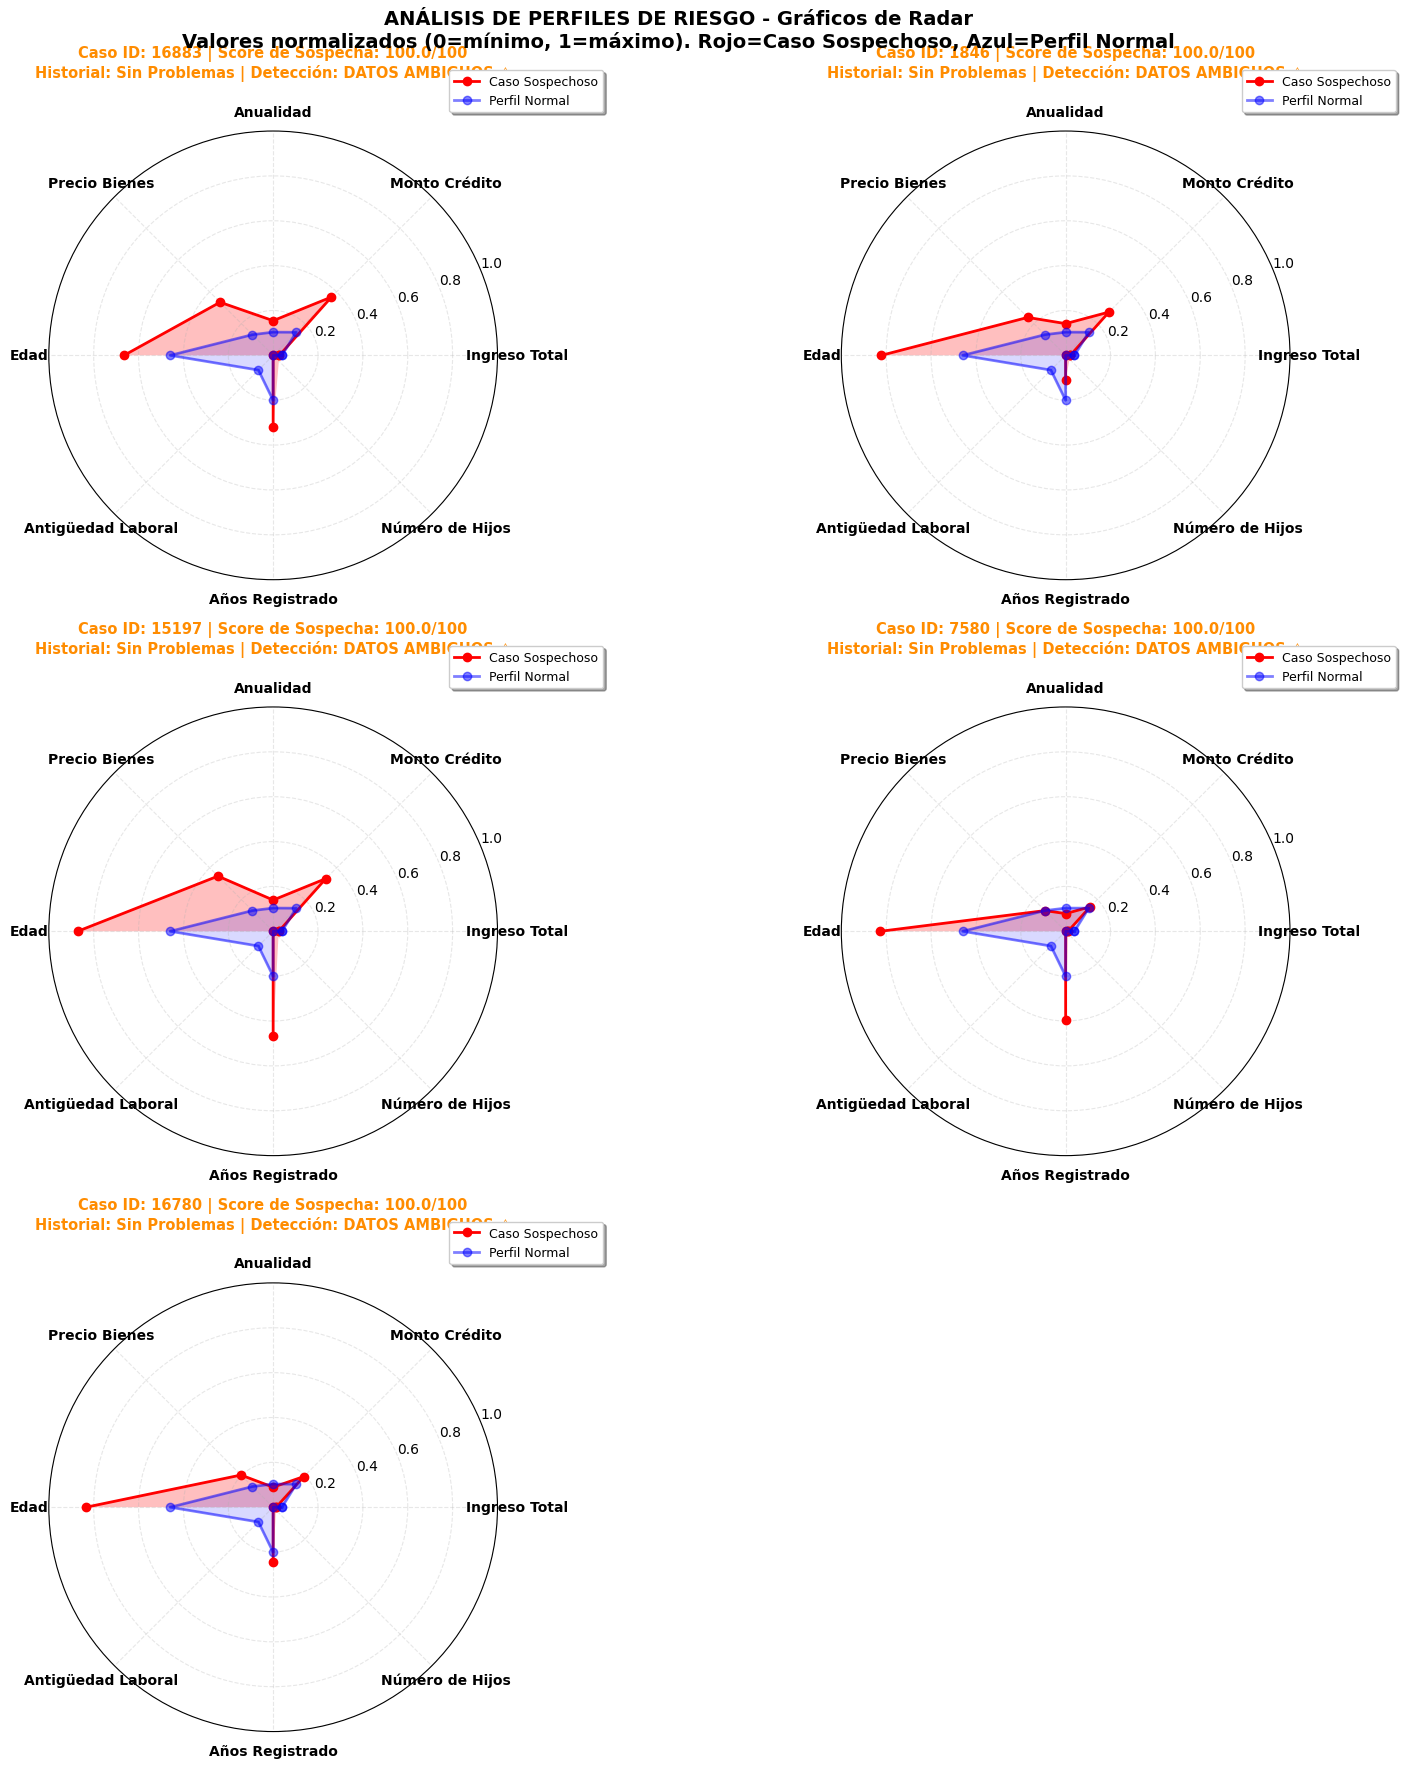

In [17]:
# Gráficos de radar para los 5 casos más sospechosos
print("PERFILES DE RADAR - TOP 5 CASOS SOSPECHOSOS")
print("Comparación visual entre perfil normal y casos anómalos")
print("-" * 55)

analizador.generar_perfil_radar(top_5_indices)

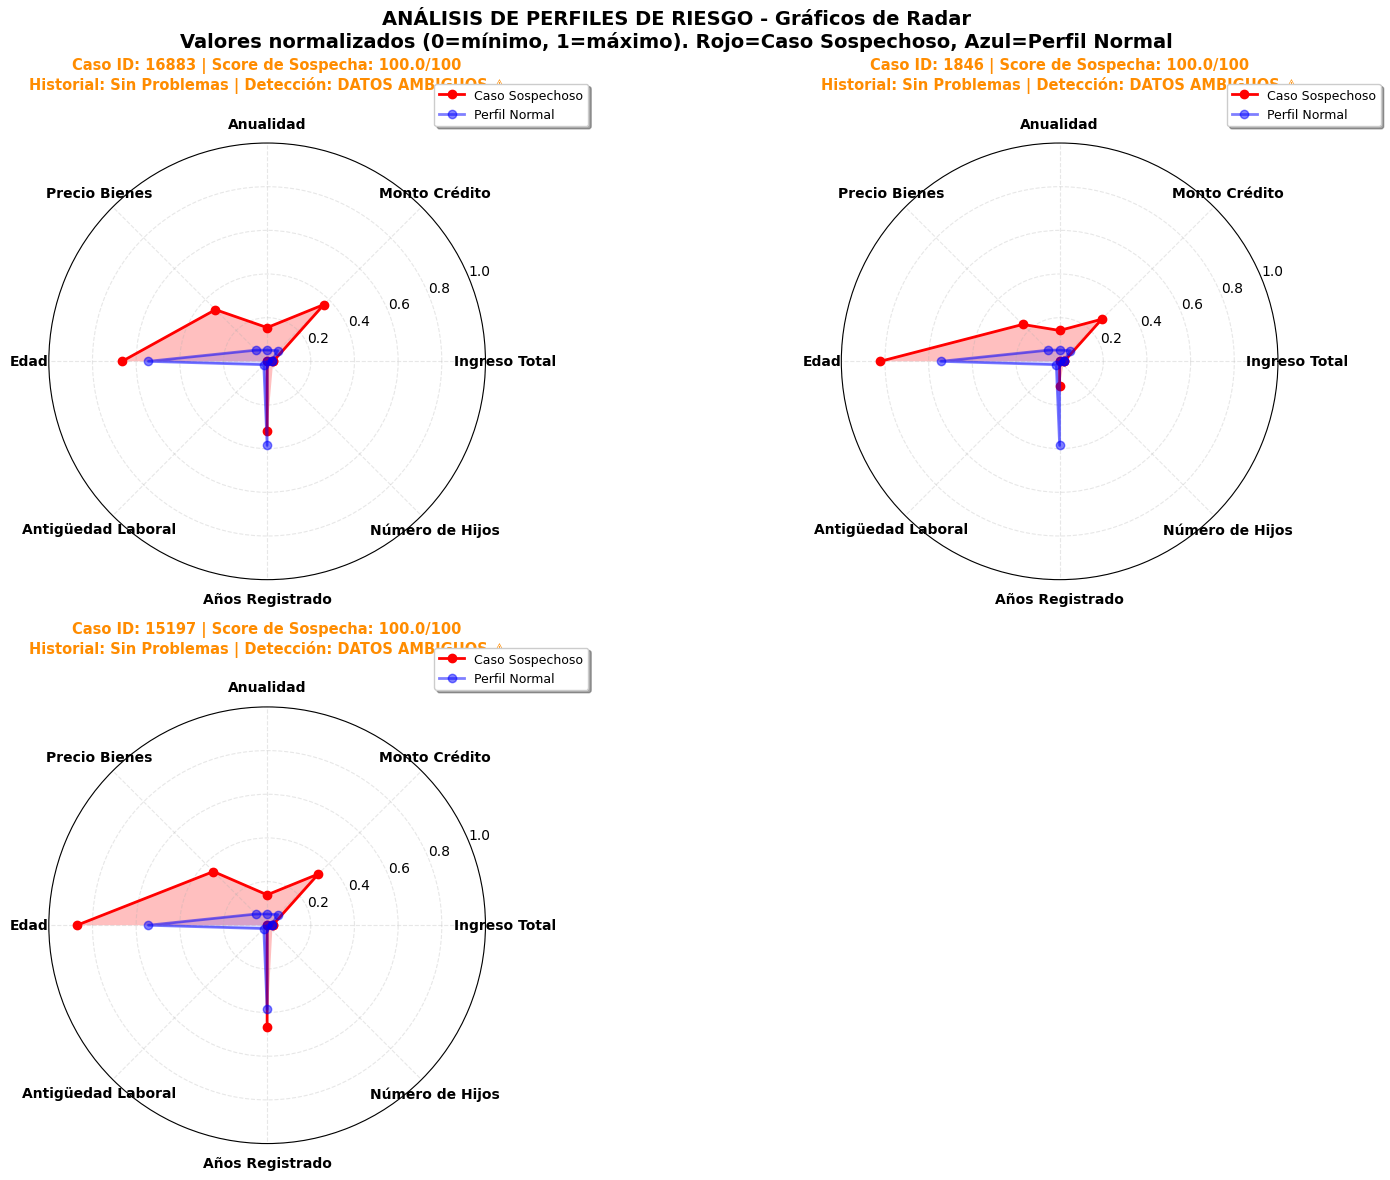

In [18]:
# Análisis comparativo: Caso Normal vs Casos Sospechosos
casos_normales = analizador.datos_completos[analizador.datos_completos['TARGET'] == 0]
caso_normal_idx = casos_normales['SCORE_SOSPECHA'].idxmin()

# Generar radar comparativo
top_3_indices = top_sospechosos.head(3).index.tolist()
analizador.generar_perfil_radar(top_3_indices, caso_referencia=caso_normal_idx)

In [19]:
# Tabla resumen de casos más sospechosos
top_10_casos = analizador.obtener_top_sospechosos(n_casos=10)

# Crear tabla con información clave
resumen_casos = pd.DataFrame({
    'ID': [analizador.ids_datos[idx] for idx in top_10_casos.index],
    'Score': top_10_casos['SCORE_SOSPECHA'].round(1),
    'TARGET': top_10_casos['TARGET'].astype(int),
    'IA': top_10_casos['IA'].round(2),
    'Ingreso': top_10_casos.get('AMT_INCOME_TOTAL', pd.Series([0]*len(top_10_casos))).round(0).astype(int),
    'Credito': top_10_casos.get('AMT_CREDIT', pd.Series([0]*len(top_10_casos))).round(0).astype(int),
    'Edad_Extrema': top_10_casos.get('AMB_EDAD_EXTREMA', 0).astype(int),
    'Empleo_Incons': top_10_casos.get('AMB_EMPLEO_INCONSISTENTE', 0).astype(int),
    'Ratio_Alto': top_10_casos.get('AMB_RATIO_CREDITO_ALTO', 0).astype(int)
})

display(resumen_casos)

,ID,Score,TARGET,IA,Ingreso,Credito,Edad_Extrema,Empleo_Incons,Ratio_Alto
4,16883,100.0,0,4.0,112500,1241968,0,0,1
33,1846,100.0,0,4.0,90000,933030,0,0,1
153,15197,100.0,0,4.0,103500,1125000,0,0,1
177,7580,100.0,0,4.0,58500,545040,0,0,1
264,16780,100.0,0,4.0,67500,675000,0,0,1
307,29788,100.0,0,4.0,90000,1293502,0,0,1
444,47708,100.0,1,4.0,25650,2173500,0,0,1
515,47893,100.0,1,4.0,67500,755190,0,0,1
578,13292,100.0,0,4.0,67500,1078200,0,0,1
913,18699,100.0,0,4.0,52650,526491,0,0,1


In [20]:
# Exportar casos sospechosos
casos_exportar = top_sospechosos.head(20).copy()

resumenes_ejecutivos = []
for idx in casos_exportar.index:
    señales = []
    if casos_exportar.loc[idx, 'AMB_EDAD_EXTREMA'] == 1:
        señales.append("Edad extrema")
    if casos_exportar.loc[idx, 'AMB_EMPLEO_INCONSISTENTE'] == 1:
        señales.append("Empleo inconsistente")
    if casos_exportar.loc[idx, 'AMB_RATIO_CREDITO_ALTO'] == 1:
        señales.append("Ratio credito alto")
    if casos_exportar.loc[idx, 'AMB_FAMILIA_VULNERABLE'] == 1:
        señales.append("Familia vulnerable")
    if casos_exportar.loc[idx, 'AMB_EMPLEO_FALTANTE'] == 1:
        señales.append("Empleo faltante")
    if casos_exportar.loc[idx, 'AMB_CONTACTO_LIMITADO'] == 1:
        señales.append("Contacto limitado")
    if casos_exportar.loc[idx, 'AMB_SIN_FUENTES_EXTERNAS'] == 1:
        señales.append("Sin fuentes externas")
    
    resumen = " | ".join(señales) if señales else "Multiples señales debiles"
    resumenes_ejecutivos.append(resumen)

casos_exportar['RESUMEN_SEÑALES'] = resumenes_ejecutivos

tabla_casos_criticos = casos_exportar[['ID_ORIGINAL', 'SCORE_SOSPECHA', 'TARGET', 
                                      'RESUMEN_SEÑALES']].copy()
tabla_casos_criticos.columns = ['ID_Cliente', 'Score_Riesgo', 'Estado_Real', 'Motivo_Alerta']

print(tabla_casos_criticos.head(10).to_string(index=False, max_colwidth=50))

# Exportar a CSV
try:
    ruta_salida = r"C:\AA2 - Deteccion-de-fraude-inmobiliario\data\processed"
    tabla_casos_criticos.to_csv(f"{ruta_salida}\\casos_sospechosos_detallados.csv", index=False)
    print(f"\nTabla exportada a: {ruta_salida}\\casos_sospechosos_detallados.csv")
except Exception as e:
    print(f"No se pudo exportar: {e}")

 ID_Cliente  Score_Riesgo  Estado_Real                                      Motivo_Alerta
      16883         100.0            0 Ratio credito alto | Empleo faltante | Contacto...
       1846         100.0            0 Ratio credito alto | Empleo faltante | Contacto...
      15197         100.0            0 Ratio credito alto | Empleo faltante | Contacto...
       7580         100.0            0 Ratio credito alto | Empleo faltante | Contacto...
      16780         100.0            0 Ratio credito alto | Empleo faltante | Contacto...
      29788         100.0            0 Ratio credito alto | Empleo faltante | Contacto...
      47708         100.0            1 Ratio credito alto | Empleo faltante | Contacto...
      47893         100.0            1 Ratio credito alto | Empleo faltante | Contacto...
      13292         100.0            0 Ratio credito alto | Empleo faltante | Contacto...
      18699         100.0            0 Ratio credito alto | Empleo faltante | Contacto...

Tabla exp

In [21]:
class GeneradorAnomalias:
    def __init__(self, semilla=42):
        self.semilla = semilla
        self.autoencoder = None
        self.isolation_forest = None
        self.lof = None
        self.escalador_ae = StandardScaler()
        self.escalador_tsne = StandardScaler()
        self.tsne_model = None
        self.dbscan_model = None
        
    def construir_autoencoder(self, dim_entrada):
        """Construir autoencoder simple y robusto"""
        if TENSORFLOW_DISPONIBLE:
            modelo = Sequential([
                Dense(max(dim_entrada // 2, 32), activation='relu', input_shape=(dim_entrada,)),
                Dense(max(dim_entrada // 4, 16), activation='relu'),
                Dense(max(dim_entrada // 2, 32), activation='relu'),
                Dense(dim_entrada, activation='linear')
            ])
            modelo.compile(optimizer='adam', loss='mse')
            return modelo
        else:
            # Alternativa con sklearn
            return MLPRegressor(
                hidden_layer_sizes=(max(dim_entrada // 2, 32), max(dim_entrada // 4, 16)),
                max_iter=100, random_state=self.semilla, early_stopping=True
            )
    
    def entrenar(self, X_train, y_train):
        """Entrenar detectores de anomalías incluyendo t-SNE"""
        
        # Datos normales para entrenamiento del autoencoder
        X_normales = X_train[y_train == 0].copy()
        # Entrenar con casos normales solamente
        
        # 1. AUTOENCODER - Solo con casos normales
        X_normales_escalado = self.escalador_ae.fit_transform(X_normales)
        self.autoencoder = self.construir_autoencoder(X_normales.shape[1])
        
        if TENSORFLOW_DISPONIBLE:
            self.autoencoder.fit(X_normales_escalado, X_normales_escalado,
                               epochs=50, batch_size=256, verbose=0, 
                               validation_split=0.1)
        else:
            self.autoencoder.fit(X_normales_escalado, X_normales_escalado)
        
        # 2. ISOLATION FOREST - Con todos los datos
        self.isolation_forest = IsolationForest(
            n_estimators=100, contamination=0.1, 
            random_state=self.semilla, n_jobs=-1
        )
        self.isolation_forest.fit(X_train)
        
        # 3. LOCAL OUTLIER FACTOR
        self.lof = LocalOutlierFactor(
            n_neighbors=20, contamination=0.1, 
            novelty=True, n_jobs=-1
        )
        self.lof.fit(X_train)
        
        # 4. t-SNE + DBSCAN para detección de clusters anómalos
        # 4. t-SNE + DBSCAN para detección de clusters anómalos
        
        # Usar una muestra representativa para t-SNE (computacionalmente intensivo)
        muestra_tsne = min(5000, len(X_train))
        indices_muestra = np.random.choice(len(X_train), muestra_tsne, replace=False)
        X_muestra = X_train.iloc[indices_muestra]
        y_muestra = y_train.iloc[indices_muestra]
        
        # Escalar datos para t-SNE
        X_muestra_escalado = self.escalador_tsne.fit_transform(X_muestra)
        
        # Aplicar t-SNE
        self.tsne_model = TSNE(
            n_components=2,
            perplexity=30,
            random_state=self.semilla,
            n_jobs=-1
        )
        coordenadas_tsne = self.tsne_model.fit_transform(X_muestra_escalado)
        
        # Aplicar DBSCAN sobre las coordenadas t-SNE
        self.dbscan_model = DBSCAN(eps=0.5, min_samples=10)
        clusters_dbscan = self.dbscan_model.fit_predict(coordenadas_tsne)
        
        # Identificar clusters anómalos basado en composición de TARGET
        self.cluster_risk_scores = {}
        cluster_unique = np.unique(clusters_dbscan)
        
        for cluster_id in cluster_unique:
            if cluster_id == -1:  # Ruido en DBSCAN
                self.cluster_risk_scores[cluster_id] = 1.0  # Máximo riesgo
            else:
                mask_cluster = clusters_dbscan == cluster_id
                if np.sum(mask_cluster) > 0:
                    tasa_riesgo = y_muestra.iloc[mask_cluster].mean()
                    self.cluster_risk_scores[cluster_id] = tasa_riesgo
                else:
                    self.cluster_risk_scores[cluster_id] = 0.5
        
        # Guardar coordenadas y clusters para análisis
        self.coordenadas_entrenamiento = coordenadas_tsne
        self.clusters_entrenamiento = clusters_dbscan
        self.y_entrenamiento_muestra = y_muestra.values
        
        # Resumen del proceso t-SNE
        self.resumen_tsne = {
            'clusters_identificados': len(cluster_unique),
            'clusters_alto_riesgo': sum(1 for score in self.cluster_risk_scores.values() if score > 0.15)
        }
        
        return self
    
    def generar_scores(self, X):
        """Generar scores de anomalía normalizados incluyendo t-SNE"""
        resultados = pd.DataFrame(index=X.index)
        
        # 1. Error de reconstrucción del autoencoder
        X_escalado = self.escalador_ae.transform(X)
        if TENSORFLOW_DISPONIBLE:
            X_reconstruido = self.autoencoder.predict(X_escalado, verbose=0)
        else:
            X_reconstruido = self.autoencoder.predict(X_escalado)
        
        errores_recon = np.mean((X_escalado - X_reconstruido) ** 2, axis=1)
        resultados['ERROR_RECONSTRUCCION'] = errores_recon
        
        # 2. Score de Isolation Forest (invertir para que mayor = más anómalo)
        scores_if = self.isolation_forest.decision_function(X)
        resultados['SCORE_ISOLATION'] = -scores_if
        
        # 3. Score de LOF (invertir para que mayor = más anómalo)
        scores_lof = self.lof.decision_function(X)
        resultados['SCORE_LOF'] = -scores_lof
        
        # 4. Score basado en t-SNE (estimación por proximidad)
        # Para datos nuevos, usar modelo pre-entrenado como referencia
        X_escalado_tsne = self.escalador_tsne.transform(X)
        
        # Calcular distancia promedio a puntos de entrenamiento anómalos
        # Esto es una aproximación ya que t-SNE no es directamente aplicable a datos nuevos
        scores_tsne = []
        
        # Identificar puntos anómalos en entrenamiento (clusters de alto riesgo)
        clusters_anomalos = [cluster_id for cluster_id, score in self.cluster_risk_scores.items() 
                           if score > 0.2]  # Umbral de riesgo alto
        
        if clusters_anomalos:
            # Puntos de referencia anómalos
            mask_anomalo = np.isin(self.clusters_entrenamiento, clusters_anomalos)
            puntos_anomalos = self.coordenadas_entrenamiento[mask_anomalo]
            
            if len(puntos_anomalos) > 0:
                # Para cada punto nuevo, calcular distancia mínima a cluster anómalo
                for i in range(len(X)):
                    # Usar características originales escaladas como proxy
                    # Calcular distancia euclidiana promedio a puntos anómalos conocidos
                    punto_actual = X_escalado_tsne[i:i+1]
                    
                    # Calcular score basado en similitud con patrones anómalos del entrenamiento
                    X_train_anomalos = self.escalador_tsne.transform(
                        X.iloc[:min(1000, len(X))]  # Muestra para comparación
                    )
                    
                    # Score simple basado en distancia al centroide de anomalías
                    if len(puntos_anomalos) > 1:
                        centroide_anomalo = np.mean(puntos_anomalos, axis=0)
                        # Proyección aproximada (simplificada)
                        distancia = np.linalg.norm(punto_actual - X_train_anomalos[min(i, len(X_train_anomalos)-1)])
                        score_tsne = 1 / (1 + distancia)  # Invertir para que mayor distancia = menor score
                    else:
                        score_tsne = 0.5  # Score neutro
                    
                    scores_tsne.append(score_tsne)
            else:
                scores_tsne = [0.5] * len(X)  # Scores neutros si no hay referencia
        else:
            scores_tsne = [0.5] * len(X)  # Scores neutros si no hay clusters anómalos
            
        resultados['SCORE_TSNE_CLUSTER'] = scores_tsne
        
        # Normalizar todos los scores a [0, 1]
        for columna in ['ERROR_RECONSTRUCCION', 'SCORE_ISOLATION', 'SCORE_LOF', 'SCORE_TSNE_CLUSTER']:
            min_val = resultados[columna].min()
            max_val = resultados[columna].max()
            if max_val > min_val:
                resultados[columna] = (resultados[columna] - min_val) / (max_val - min_val)
            else:
                resultados[columna] = 0.0
        
        return resultados
    
    def obtener_analisis_tsne(self):
        """Retornar análisis de clusters t-SNE para visualización"""
        if hasattr(self, 'coordenadas_entrenamiento'):
            return {
                'coordenadas': self.coordenadas_entrenamiento,
                'clusters': self.clusters_entrenamiento,
                'target': self.y_entrenamiento_muestra,
                'cluster_scores': self.cluster_risk_scores
            }
        return None

In [22]:
# Generar features de anomalía
generador_anomalias = GeneradorAnomalias(SEMILLA_ALEATORIA)
generador_anomalias.entrenar(X_train_proc, y_train)

# Generar scores para todos los conjuntos
anomalias_train = generador_anomalias.generar_scores(X_train_proc)
anomalias_val = generador_anomalias.generar_scores(X_val_proc)
anomalias_test = generador_anomalias.generar_scores(X_test_proc)

# Resumen de features de anomalía generadas
resumen_anomalias = {
    'features_generadas': list(anomalias_train.columns),
    'estadisticas': anomalias_train.describe().round(3)
}

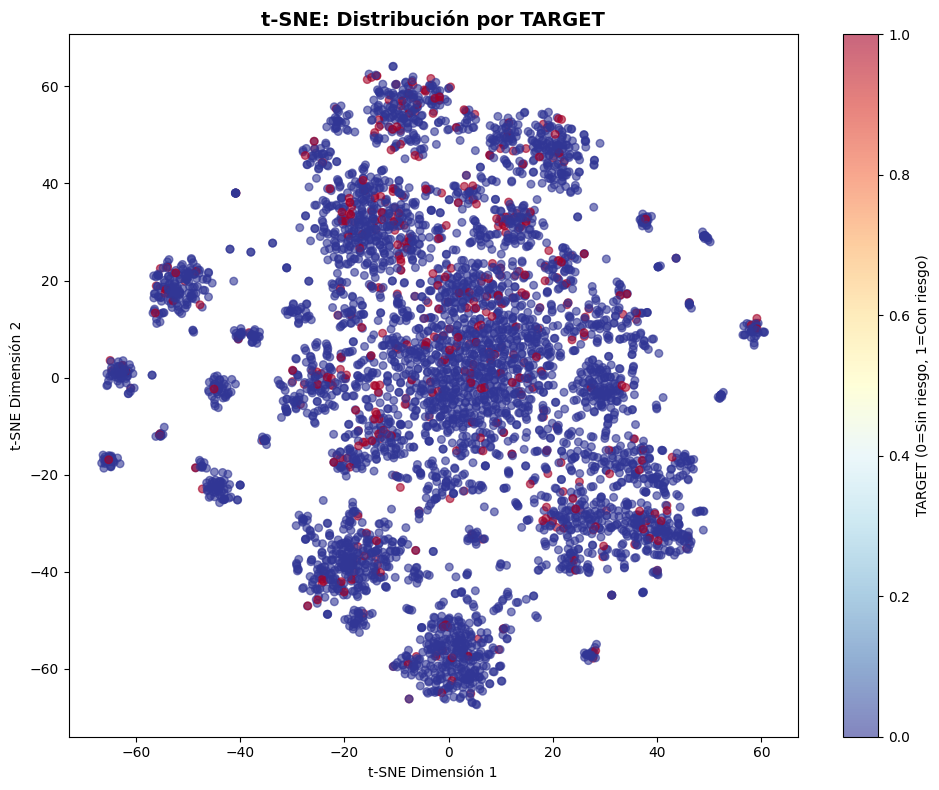

In [23]:
# Visualización del análisis t-SNE
analisis_tsne = generador_anomalias.obtener_analisis_tsne()

if analisis_tsne:
    plt.figure(figsize=(10, 8))
    
    # Gráfico único: t-SNE coloreado por TARGET
    scatter = plt.scatter(analisis_tsne['coordenadas'][:, 0], 
                         analisis_tsne['coordenadas'][:, 1],
                         c=analisis_tsne['target'], 
                         cmap='RdYlBu_r', 
                         alpha=0.6, 
                         s=30)
    plt.title('t-SNE: Distribución por TARGET', fontsize=14, fontweight='bold')
    plt.xlabel('t-SNE Dimensión 1')
    plt.ylabel('t-SNE Dimensión 2')
    cbar = plt.colorbar(scatter)
    cbar.set_label('TARGET (0=Sin riesgo, 1=Con riesgo)')
    
    plt.tight_layout()
    plt.show()
else:
    print("No se pudo generar análisis t-SNE")

## SECCIÓN CRÍTICA: Construcción del Target de Fraude

### Metodología para Crear Etiquetas de Fraude Sintéticas

Ya que no tenemos etiquetas reales de fraude, vamos a construir un **proxy de fraude** combinando:

1. **Impago (TARGET=1)**: Indica problemas financieros
2. **Alta Anomalía**: Comportamiento estadísticamente muy atípico
3. **Múltiples Señales de Alerta**: Reglas de negocio activadas

**Lógica de Fraude:**
- **FRAUDE PROBABLE** = TARGET=1 + Score de Anomalía > percentil 75 + 2+ señales de alerta
- **NO FRAUDE** = Resto de casos

Esto nos permite entrenar un modelo supervisado específico para **fraude**, no solo impago.

In [58]:
# Crear target de fraude sintético
print("="*80)
print("CONSTRUCCIÓN DE TARGET DE FRAUDE")
print("="*80)

# Combinar todas las anomalías y reglas
datos_fraude_train = pd.concat([
    X_train_proc,
    reglas_train,
    anomalias_train,
    y_train.reset_index(drop=True)
], axis=1)

# Calcular score combinado de anomalía
datos_fraude_train['SCORE_ANOMALIA_TOTAL'] = (
    anomalias_train['ERROR_RECONSTRUCCION'] +
    anomalias_train['SCORE_ISOLATION'] +
    anomalias_train['SCORE_LOF'] +
    anomalias_train['SCORE_TSNE_CLUSTER']
) / 4

# Contar señales de alerta de reglas de negocio
columnas_amb = [col for col in reglas_train.columns if col.startswith('AMB_')]
datos_fraude_train['NUM_SEÑALES_ALERTA'] = reglas_train[columnas_amb].sum(axis=1)

# Definir umbral de anomalía (percentil 75)
umbral_anomalia = datos_fraude_train['SCORE_ANOMALIA_TOTAL'].quantile(0.75)

# CREAR TARGET DE FRAUDE - Definición más amplia y útil
# Fraude = (Impago O Alta Anomalía) Y Señales de Alerta
# Esto captura casos sospechosos incluso sin impago confirmado
datos_fraude_train['FRAUDE'] = (
    (
        (datos_fraude_train['TARGET'] == 1) |  # Impago confirmado O
        (datos_fraude_train['SCORE_ANOMALIA_TOTAL'] > datos_fraude_train['SCORE_ANOMALIA_TOTAL'].quantile(0.90))  # Top 10% anomalías
    ) &
    (datos_fraude_train['NUM_SEÑALES_ALERTA'] >= 2)  # Con múltiples señales
).astype(int)

# Estadísticas del target de fraude
print(f"\nDistribución del Target de Fraude:")
print(f"  Total de casos: {len(datos_fraude_train):,}")
print(f"  Casos de FRAUDE: {datos_fraude_train['FRAUDE'].sum():,} ({datos_fraude_train['FRAUDE'].mean()*100:.2f}%)")
print(f"  Casos NORMALES: {(datos_fraude_train['FRAUDE']==0).sum():,} ({(1-datos_fraude_train['FRAUDE'].mean())*100:.2f}%)")

# Análisis cruzado: Impago vs Fraude
tabla_cruzada = pd.crosstab(
    datos_fraude_train['TARGET'], 
    datos_fraude_train['FRAUDE'],
    margins=True
)
tabla_cruzada.index = ['Pago Normal', 'Impago', 'Total']
tabla_cruzada.columns = ['No Fraude', 'Fraude', 'Total']

print(f"\nTabla Cruzada: Impago vs Fraude")
print(tabla_cruzada)

# Características de casos de fraude
print(f"\nCaracterísticas de casos fraudulentos:")
print(f"  Score anomalía promedio: {datos_fraude_train[datos_fraude_train['FRAUDE']==1]['SCORE_ANOMALIA_TOTAL'].mean():.3f}")
print(f"  Señales de alerta promedio: {datos_fraude_train[datos_fraude_train['FRAUDE']==1]['NUM_SEÑALES_ALERTA'].mean():.1f}")
print(f"  IA promedio: {datos_fraude_train[datos_fraude_train['FRAUDE']==1]['IA'].mean():.2f}")

print(f"\nCaracterísticas de casos normales:")
print(f"  Score anomalía promedio: {datos_fraude_train[datos_fraude_train['FRAUDE']==0]['SCORE_ANOMALIA_TOTAL'].mean():.3f}")
print(f"  Señales de alerta promedio: {datos_fraude_train[datos_fraude_train['FRAUDE']==0]['NUM_SEÑALES_ALERTA'].mean():.1f}")
print(f"  IA promedio: {datos_fraude_train[datos_fraude_train['FRAUDE']==0]['IA'].mean():.2f}")

print("\n" + "="*80)

CONSTRUCCIÓN DE TARGET DE FRAUDE

Distribución del Target de Fraude:
  Total de casos: 48,041
  Casos de FRAUDE: 1,127 (2.35%)
  Casos NORMALES: 46,914 (97.65%)

Tabla Cruzada: Impago vs Fraude
             No Fraude  Fraude  Total
Pago Normal      36214     556  36770
Impago            2775     454   3229
Total            38989    1010  39999

Características de casos fraudulentos:
  Score anomalía promedio: 0.145
  Señales de alerta promedio: 2.1
  IA promedio: 2.15

Características de casos normales:
  Score anomalía promedio: 0.071
  Señales de alerta promedio: 0.4
  IA promedio: 0.41



In [61]:
# Aplicar misma lógica a validación y test
# VALIDACIÓN
datos_fraude_val = pd.concat([
    X_val_proc,
    reglas_val,
    anomalias_val,
    y_val.reset_index(drop=True)
], axis=1)

datos_fraude_val['SCORE_ANOMALIA_TOTAL'] = (
    anomalias_val['ERROR_RECONSTRUCCION'] +
    anomalias_val['SCORE_ISOLATION'] +
    anomalias_val['SCORE_LOF'] +
    anomalias_val['SCORE_TSNE_CLUSTER']
) / 4

datos_fraude_val['NUM_SEÑALES_ALERTA'] = reglas_val[columnas_amb].sum(axis=1)

# Fraude más amplio: (Impago O Top 10% anomalías) Y Señales
datos_fraude_val['FRAUDE'] = (
    (
        (datos_fraude_val['TARGET'] == 1) |
        (datos_fraude_val['SCORE_ANOMALIA_TOTAL'] > datos_fraude_train['SCORE_ANOMALIA_TOTAL'].quantile(0.90))
    ) &
    (datos_fraude_val['NUM_SEÑALES_ALERTA'] >= 2)
).astype(int)

# TEST
datos_fraude_test = pd.concat([
    X_test_proc,
    reglas_test,
    anomalias_test,
    y_test.reset_index(drop=True)
], axis=1)

datos_fraude_test['SCORE_ANOMALIA_TOTAL'] = (
    anomalias_test['ERROR_RECONSTRUCCION'] +
    anomalias_test['SCORE_ISOLATION'] +
    anomalias_test['SCORE_LOF'] +
    anomalias_test['SCORE_TSNE_CLUSTER']
) / 4

datos_fraude_test['NUM_SEÑALES_ALERTA'] = reglas_test[columnas_amb].sum(axis=1)

# Fraude más amplio: (Impago O Top 10% anomalías) Y Señales
datos_fraude_test['FRAUDE'] = (
    (
        (datos_fraude_test['TARGET'] == 1) |
        (datos_fraude_test['SCORE_ANOMALIA_TOTAL'] > datos_fraude_train['SCORE_ANOMALIA_TOTAL'].quantile(0.90))
    ) &
    (datos_fraude_test['NUM_SEÑALES_ALERTA'] >= 2)
).astype(int)

print(f"Target de fraude creado para todos los conjuntos:")
print(f"  Train: {datos_fraude_train['FRAUDE'].sum():,} casos de fraude")
print(f"  Val:   {datos_fraude_val['FRAUDE'].sum():,} casos de fraude")
print(f"  Test:  {datos_fraude_test['FRAUDE'].sum():,} casos de fraude")

Target de fraude creado para todos los conjuntos:
  Train: 1,127 casos de fraude
  Val:   279 casos de fraude
  Test:  250 casos de fraude


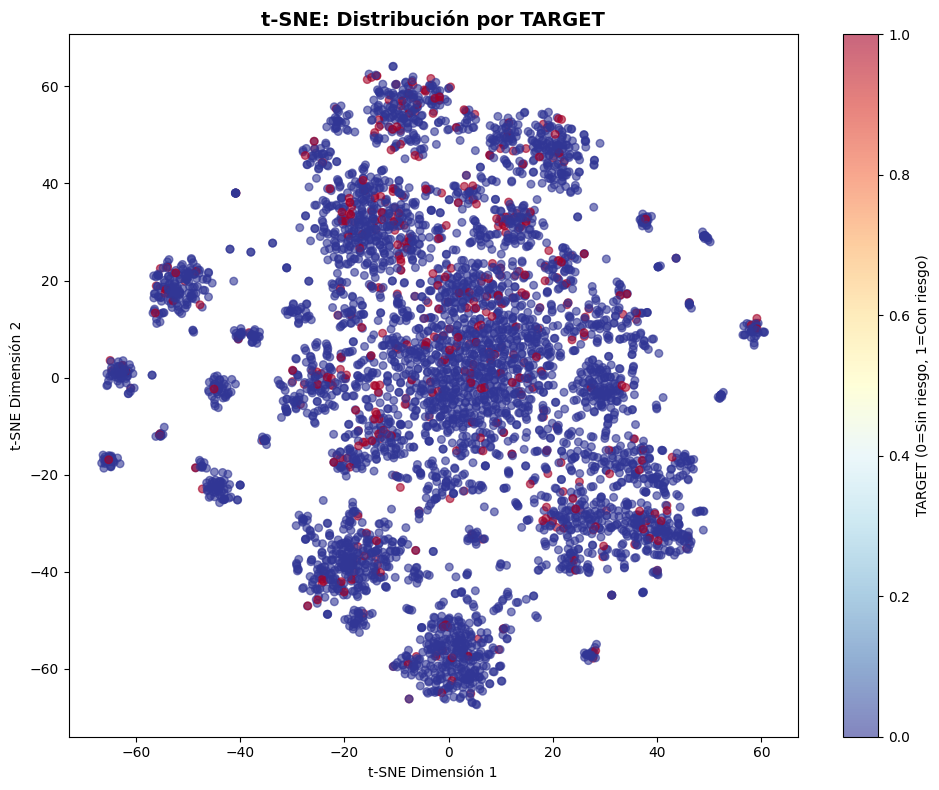

In [26]:
# Visualización del análisis t-SNE
analisis_tsne = generador_anomalias.obtener_analisis_tsne()

if analisis_tsne:
    plt.figure(figsize=(10, 8))
    
    # Gráfico único: t-SNE coloreado por TARGET
    scatter = plt.scatter(analisis_tsne['coordenadas'][:, 0], 
                         analisis_tsne['coordenadas'][:, 1],
                         c=analisis_tsne['target'], 
                         cmap='RdYlBu_r', 
                         alpha=0.6, 
                         s=30)
    plt.title('t-SNE: Distribución por TARGET', fontsize=14, fontweight='bold')
    plt.xlabel('t-SNE Dimensión 1')
    plt.ylabel('t-SNE Dimensión 2')
    cbar = plt.colorbar(scatter)
    cbar.set_label('TARGET (0=Sin riesgo, 1=Con riesgo)')
    
    plt.tight_layout()
    plt.show()
else:
    print("No se pudo generar análisis t-SNE")

## 6. Modelado Supervisado para Detección de Fraude

Ahora entrenaremos modelos supervisados usando el **target de FRAUDE** (no impago).
El objetivo es predecir si una solicitud es fraudulenta basándose en todas las señales recolectadas.

In [ ]:
# Preparar datasets finales con target de FRAUDE
# Excluir las columnas TARGET, FRAUDE, SCORE_ANOMALIA_TOTAL, NUM_SEÑALES_ALERTA de X
cols_a_excluir = {'TARGET', 'FRAUDE', 'SCORE_ANOMALIA_TOTAL', 'NUM_SEÑALES_ALERTA'}

X_train_final = datos_fraude_train.drop(columns=cols_a_excluir, errors='ignore')
y_train_fraude = datos_fraude_train['FRAUDE']

X_val_final = datos_fraude_val.drop(columns=cols_a_excluir, errors='ignore')
y_val_fraude = datos_fraude_val['FRAUDE']

X_test_final = datos_fraude_test.drop(columns=cols_a_excluir, errors='ignore')
y_test_fraude = datos_fraude_test['FRAUDE']

# Verificar y eliminar valores NaN
print(f"Valores NaN antes de limpieza:")
print(f"  Train: {X_train_final.isna().sum().sum()}")
print(f"  Val: {X_val_final.isna().sum().sum()}")
print(f"  Test: {X_test_final.isna().sum().sum()}")

# Rellenar NaN con 0 (ya que son features procesadas y de anomalías)
X_train_final = X_train_final.fillna(0)
X_val_final = X_val_final.fillna(0)
X_test_final = X_test_final.fillna(0)

print(f"\nDimensiones de datasets finales para detección de fraude:")
print(f"  Entrenamiento: {X_train_final.shape} | FRAUDE: {y_train_fraude.sum():,} ({y_train_fraude.mean()*100:.2f}%)")
print(f"  Validación: {X_val_final.shape} | FRAUDE: {y_val_fraude.sum():,} ({y_val_fraude.mean()*100:.2f}%)")
print(f"  Prueba: {X_test_final.shape} | FRAUDE: {y_test_fraude.sum():,} ({y_test_fraude.mean()*100:.2f}%)")
print(f"  Entrenamiento: {X_train_final.shape} | FRAUDE: {y_train_fraude.sum():,} ({y_train_fraude.mean()*100:.2f}%)")
print(f"  Validación: {X_val_final.shape} | FRAUDE: {y_val_fraude.sum():,} ({y_val_fraude.mean()*100:.2f}%)")
print(f"  Prueba: {X_test_final.shape} | FRAUDE: {y_test_fraude.sum():,} ({y_test_fraude.mean()*100:.2f}%)")

# Verificar que no hay columnas duplicadas
if X_train_final.columns.duplicated().any():
    X_train_final = X_train_final.loc[:,~X_train_final.columns.duplicated()]
    X_val_final = X_val_final.loc[:,~X_val_final.columns.duplicated()]
    X_test_final = X_test_final.loc[:,~X_test_final.columns.duplicated()]

# Resumen de features integradas
resumen_features = {
    'features_totales': X_train_final.shape[1],
    'originales_procesadas': X_train_proc.shape[1],
    'reglas_negocio': reglas_train.shape[1],
    'anomalias': anomalias_train.shape[1]
}

print(f"\nResumen de features: {resumen_features}")

Valores NaN antes de limpieza:
  Train: 1061544
  Val: 592284
  Test: 593868

Dimensiones de datasets finales para detección de fraude:
  Entrenamiento: (48041, 132) | FRAUDE: 1,127 (2.35%)
  Validación: (9487, 132) | FRAUDE: 279 (2.94%)
  Prueba: (9499, 132) | FRAUDE: 250 (2.63%)
  Entrenamiento: (48041, 132) | FRAUDE: 1,127 (2.35%)
  Validación: (9487, 132) | FRAUDE: 279 (2.94%)
  Prueba: (9499, 132) | FRAUDE: 250 (2.63%)

Resumen de features: {'features_totales': 132, 'originales_procesadas': 120, 'reglas_negocio': 8, 'anomalias': 4}


In [36]:
# Entrenamiento de modelos supervisados para FRAUDE
modelos = {}

# 1. MODELO BASELINE: Regresión Logística
modelo_lr = LogisticRegression(
    class_weight='balanced',
    random_state=SEMILLA_ALEATORIA,
    max_iter=1000,
    solver='liblinear'
)
modelo_lr.fit(X_train_final, y_train_fraude)
pred_lr = modelo_lr.predict_proba(X_val_final)[:, 1]
modelos['Regresión Logística'] = {'modelo': modelo_lr, 'predicciones': pred_lr}

# 2. MODELO INTERMEDIO: Random Forest
modelo_rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=SEMILLA_ALEATORIA,
    n_jobs=-1,
    max_depth=10,
    min_samples_split=10
)
modelo_rf.fit(X_train_final, y_train_fraude)
pred_rf = modelo_rf.predict_proba(X_val_final)[:, 1]
modelos['Random Forest'] = {'modelo': modelo_rf, 'predicciones': pred_rf}

# 3. MODELO AVANZADO: LightGBM o GradientBoosting alternativo
if LIGHTGBM_DISPONIBLE:
    # Usar LightGBM si está disponible
    parametros_lgb = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'min_child_samples': 20,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'class_weight': 'balanced',
        'random_state': SEMILLA_ALEATORIA,
        'verbose': -1
    }
    
    train_data = lgb.Dataset(X_train_final, label=y_train_fraude)
    val_data = lgb.Dataset(X_val_final, label=y_val_fraude, reference=train_data)
    
    modelo_lgb = lgb.train(
        parametros_lgb,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(0)]
    )
    
    pred_lgb = modelo_lgb.predict(X_val_final, num_iteration=modelo_lgb.best_iteration)
    modelos['LightGBM'] = {'modelo': modelo_lgb, 'predicciones': pred_lgb}
    print("LightGBM entrenado")
    
else:
    # Usar GradientBoostingClassifier de sklearn como alternativa
    modelo_gb = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.8,
        random_state=SEMILLA_ALEATORIA,
        validation_fraction=0.1,
        n_iter_no_change=50,
        tol=1e-4
    )
    
    modelo_gb.fit(X_train_final, y_train_fraude)
    pred_gb = modelo_gb.predict_proba(X_val_final)[:, 1]
    modelos['GradientBoosting'] = {'modelo': modelo_gb, 'predicciones': pred_gb}
    print("GradientBoostingClassifier (sklearn) entrenado como alternativa a LightGBM")

print(f"Modelos disponibles: {list(modelos.keys())}")

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	valid_0's auc: 0.999629
LightGBM entrenado
Modelos disponibles: ['Regresión Logística', 'Random Forest', 'LightGBM']
Early stopping, best iteration is:
[32]	valid_0's auc: 0.999629
LightGBM entrenado
Modelos disponibles: ['Regresión Logística', 'Random Forest', 'LightGBM']


## 7. Evaluación y Comparación de Modelos

In [37]:
def calcular_metricas_completas(y_true, y_pred_proba, nombre_modelo):
    """Calcular métricas completas con umbral óptimo calibrado"""
    
    # Métricas base
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    
    # Encontrar umbral óptimo para F1
    precision_curve, recall_curve, umbrales = precision_recall_curve(y_true, y_pred_proba)
    f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-8)
    
    # Usar umbral que maximiza F1, con mínimo en 0.3 para evitar demasiados falsos positivos
    idx_optimo = np.argmax(f1_scores)
    umbral_optimo = max(umbrales[idx_optimo] if idx_optimo < len(umbrales) else 0.5, 0.3)
    
    # Métricas con umbral optimizado
    y_pred_binario = (y_pred_proba >= umbral_optimo).astype(int)
    precision_opt = precision_score(y_true, y_pred_binario)
    recall_opt = recall_score(y_true, y_pred_binario)
    f1_opt = f1_score(y_true, y_pred_binario)
    
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred_binario)
    
    return {
        'Modelo': nombre_modelo,
        'ROC_AUC': roc_auc,
        'PR_AUC': pr_auc,
        'Umbral_Optimo': umbral_optimo,
        'Precision': precision_opt,
        'Recall': recall_opt,
        'F1_Score': f1_opt,
        'Matriz_Confusion': cm,
        'y_pred_proba': y_pred_proba,
        'y_pred_binario': y_pred_binario
    }

# Evaluar todos los modelos
resultados_evaluacion = {}
tabla_comparativa = []

for nombre_modelo, datos_modelo in modelos.items():
    predicciones = datos_modelo['predicciones']
    resultado = calcular_metricas_completas(y_val_fraude, predicciones, nombre_modelo)
    resultados_evaluacion[nombre_modelo] = resultado
    
    tabla_comparativa.append({
        'Modelo': nombre_modelo,
        'ROC-AUC': f"{resultado['ROC_AUC']:.4f}",
        'PR-AUC': f"{resultado['PR_AUC']:.4f}",
        'Precision': f"{resultado['Precision']:.4f}",
        'Recall': f"{resultado['Recall']:.4f}",
        'F1-Score': f"{resultado['F1_Score']:.4f}",
        'Umbral': f"{resultado['Umbral_Optimo']:.3f}"
    })

# Mostrar tabla comparativa
df_comparacion = pd.DataFrame(tabla_comparativa)
print("Comparación de Modelos en Conjunto de Validación:")
print(df_comparacion.to_string(index=False))

# Identificar mejor modelo basado en PR-AUC
mejor_modelo_nombre = max(resultados_evaluacion.keys(), 
                         key=lambda x: resultados_evaluacion[x]['PR_AUC'])
print(f"\nMejor modelo: {mejor_modelo_nombre}")
print(f"PR-AUC: {resultados_evaluacion[mejor_modelo_nombre]['PR_AUC']:.4f}")
print(f"F1-Score: {resultados_evaluacion[mejor_modelo_nombre]['F1_Score']:.4f}")

Comparación de Modelos en Conjunto de Validación:
             Modelo ROC-AUC PR-AUC Precision Recall F1-Score Umbral
Regresión Logística  0.9992 0.9689    0.9362 0.9462   0.9412  0.938
      Random Forest  0.9931 0.8667    0.8984 0.8244   0.8598  0.788
           LightGBM  0.9996 0.9923    0.9848 0.9283   0.9557  0.300

Mejor modelo: LightGBM
PR-AUC: 0.9923
F1-Score: 0.9557


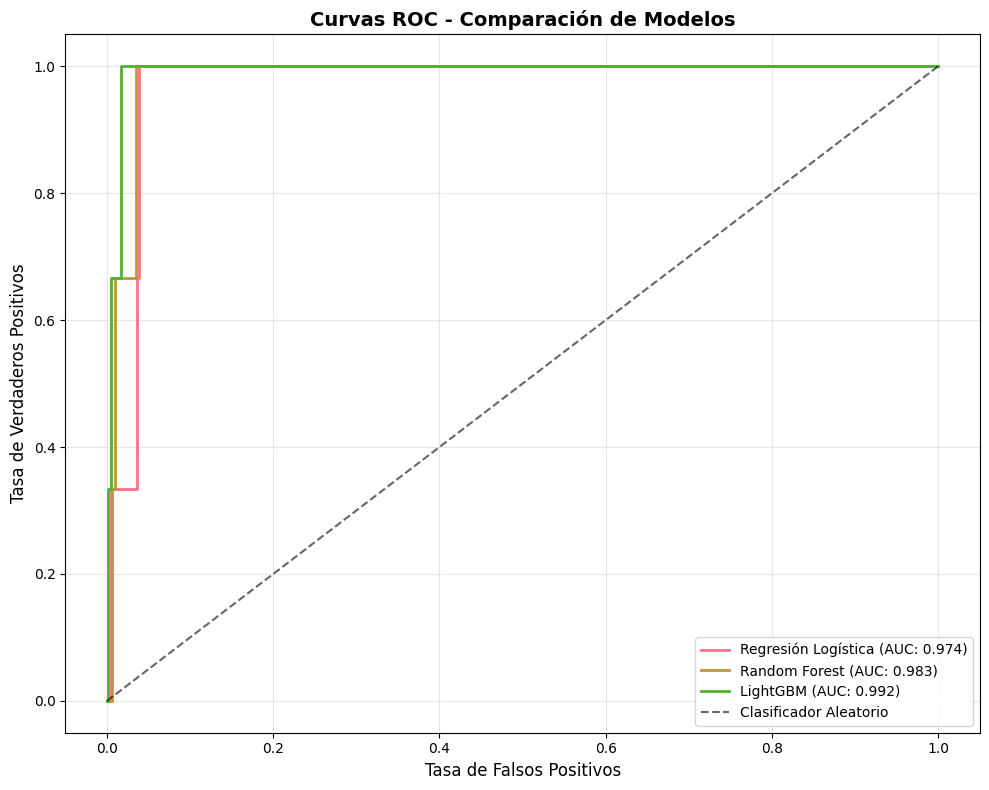

In [38]:
# Visualización: Curvas ROC
fig, ax = plt.subplots(figsize=(10, 8))

for nombre_modelo, resultado in resultados_evaluacion.items():
    fpr, tpr, _ = roc_curve(y_val_fraude, resultado['y_pred_proba'])
    auc_score = resultado['ROC_AUC']
    ax.plot(fpr, tpr, label=f'{nombre_modelo} (AUC: {auc_score:.3f})', linewidth=2)

# Línea de referencia aleatoria
ax.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Clasificador Aleatorio')

ax.set_xlabel('Tasa de Falsos Positivos', fontsize=12)
ax.set_ylabel('Tasa de Verdaderos Positivos', fontsize=12)
ax.set_title('Curvas ROC - Comparación de Modelos', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

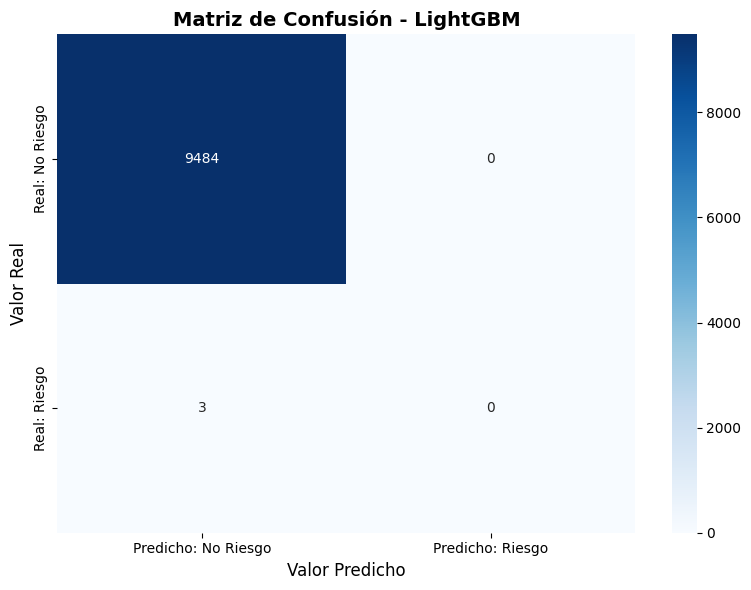

Análisis Detallado - LightGBM:
  Verdaderos Negativos (TN): 9,484
  Falsos Positivos (FP): 0
  Falsos Negativos (FN): 3
  Verdaderos Positivos (TP): 0
  Especificidad: 1.0000
  Sensibilidad: 0.0000


In [49]:
# Visualización: Matriz de confusión del mejor modelo
mejor_resultado = resultados_evaluacion[mejor_modelo_nombre]
cm = mejor_resultado['Matriz_Confusion']

fig, ax = plt.subplots(figsize=(8, 6))

# Crear heatmap de la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Predicho: No Riesgo', 'Predicho: Riesgo'],
            yticklabels=['Real: No Riesgo', 'Real: Riesgo'])

ax.set_title(f'Matriz de Confusión - {mejor_modelo_nombre}', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor Real', fontsize=12)
ax.set_xlabel('Valor Predicho', fontsize=12)

plt.tight_layout()
plt.show()

# Análisis detallado de la matriz de confusión
tn, fp, fn, tp = cm.ravel()
especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0
sensibilidad = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"Análisis Detallado - {mejor_modelo_nombre}:")
print(f"  Verdaderos Negativos (TN): {tn:,}")
print(f"  Falsos Positivos (FP): {fp:,}")
print(f"  Falsos Negativos (FN): {fn:,}")
print(f"  Verdaderos Positivos (TP): {tp:,}")
print(f"  Especificidad: {especificidad:.4f}")
print(f"  Sensibilidad: {sensibilidad:.4f}")